In [256]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets
import os
import SimpleITK as sitk
import radiomics
from radiomics import featureextractor, shape, shape2D
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, MinMaxScaler, MaxAbsScaler, PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, recall_score, precision_score, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample
from sklearn.decomposition import PCA
from collections import defaultdict
import statsmodels.api as sm
from PIL import Image
import gc
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from imblearn.over_sampling import SMOTE
import json
import re


In [80]:
source_PI_CAI = r'Data/picai_public_images'
source_PI_CAI_whole_gland_Guerbet23 = r'Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23'
source_PI_CAI_Human = r'Data/picai_public_images/csPCa_lesion_delineations/human_expert/resampled'
source_PI_CAI_resampled = r'Data/t2w_spacing_resampled'
source_PI_CAI_resampled_whole_gland_Guerbet23 = r'Data/Guerbet23_resampled'
source_PI_CAI_resampled_Human = r'Data/Human_resampled'
marksheet_path = r'Data\marksheet.csv'

In [210]:
def parse_gleason(gs):
    """Extract primary and secondary grades from a Gleason score string like '4+3'."""
    match = re.match(r'(\d+)\+(\d+)', gs)
    if match:
        primary, secondary = int(match.group(1)), int(match.group(2))
        return (primary + secondary, primary)  # prioritize higher total, then higher primary
    return (-1, -1)  # fallback for invalid patterns

def get_highest_gleason_score(gleason_scores):
    score_mapping = {
        "0+0": 0,
        "3+3": 1,
        "3+4": 2,
        "4+3": 3,
        "4+4": 4,
        "3+5": 5,
        "5+3": 6,
        "5+4": 7,
        "4+5": 8,
        "5+5": 9,
        "5+5": 10
    }
    return max(gleason_scores, key=lambda x: score_mapping.get(x, -1))

def is_csPCa(gs):
    try:
        total, primary = parse_gleason(gs)
        return int(total >= 7 and (primary == 4 or primary == 5))
    except:
        return 0

def find_t2W_files(dir, combined_ids, fileinfo):
    dir = os.path.normpath(dir)
    t2w_file_paths = []

    for subdir, dirs, files in os.walk(dir):
        subdir = os.path.normpath(subdir)
        for file in files:
            if any(file.endswith(combined_id + fileinfo) for combined_id in combined_ids):
                t2w_file_paths.append(os.path.join(subdir, file))

    return t2w_file_paths

def preprocess_data(df):
    print(f"Initial dataset length: {len(df)}")

    # 1. Drop data with missing values in the column "PSA" or "Volume"
    df = df.dropna(subset=['psa'])
    print(f"Dataset length after dropping rows with missing psa: {len(df)}")
     
    df = df.dropna(subset=['prostate_volume'])
    print(f"Dataset length after dropping rows with missing prostate volume: {len(df)}")

    # 2. Remove patients with unvalid gleason scores
    valid_gleason_scores = ["0+0", "3+3", "3+4", "4+3", "4+4", "5+4", "4+5", "5+5"]
    df['lesion_GS'] = df['lesion_GS'].str.split(',')
    df_exploded = df.explode('lesion_GS').reset_index(drop=True)
    df_exploded['lesion_GS'] = df_exploded['lesion_GS'].str.strip()
    df_exploded = df_exploded[df_exploded['lesion_GS'].isin(valid_gleason_scores)]
    df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'] \
    .apply(lambda x: get_highest_gleason_score(x)) \
    .reset_index()
    df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')
    print(f"Dataset length after filtering gleason scores: {len(df)}")
    
    # 3. Filter out patients with no biopsy
    biopsy_filter = df['histopath_type'].isin(['MRBx', 'SysBx', 'SysBx+MRBx'])
    df = df[biopsy_filter]
    print(f"Dataset length after filtering biopsies: {len(df)}")

    # 4. Convert case_csPCa to binary (1: True, 0: False)
    df['case_csPCa'] = df['case_csPCa'].apply(lambda x: 1 if x.upper() == 'YES' else 0)


    
    # Combined ids for use as a unique identifier
    sorted_patient_id = df['patient_id']
    sorted_study_id = df['study_id']
    combined_ids = sorted_patient_id.astype(str) + '_' + sorted_study_id.astype(str)

    return df, combined_ids

def save_df(df, dir, filename, gland_type):
    path = os.path.join(dir, f"{filename}_{gland_type}.csv")
    df.to_csv(path, index=False)
    print(f"File saved as {path}")

def calculate_psad(df):
    mask = df['psad'].isna() & df['psa'].notna() & df['prostate_volume'].notna()
    df.loc[mask, 'psad'] = (df.loc[mask, 'psa'] / df.loc[mask, 'prostate_volume']).round(2)
    
    return df


In [211]:
marksheet_df = pd.read_csv(marksheet_path)
Preprocessed_marksheet_df, combined_ids = preprocess_data(marksheet_df)

Preprocessed_marksheet_df = calculate_psad(Preprocessed_marksheet_df)
save_df(Preprocessed_marksheet_df, 'Data', 'Preprocessed_marksheet', 'all')
Preprocessed_marksheet_df


Initial dataset length: 1500
Dataset length after dropping rows with missing psa: 1460
Dataset length after dropping rows with missing prostate volume: 1439
Dataset length after filtering gleason scores: 956
Dataset length after filtering biopsies: 931
File saved as Data\Preprocessed_marksheet_all.csv


,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_ISUP,case_ISUP,case_csPCa,center,lesion_GS
0,10000,1000000,2019-07-02,73,7.70,0.14,55.0,MRBx,0,0,0,PCNN,0+0
1,10003,1000003,2019-04-05,72,13.00,0.18,71.5,SysBx,0,0,0,ZGT,0+0
2,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0,0",0,0,RUMC,0+0
3,10005,1000005,2012-07-18,64,12.10,0.24,51.0,MRBx,"3,0",3,1,RUMC,4+3
4,10006,1000006,2020-10-23,73,6.20,0.23,27.0,SysBx+MRBx,"0,1",1,0,ZGT,3+3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"2,1",2,1,RUMC,3+4
952,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,2,2,1,RUMC,3+4
953,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0,0,0,RUMC,0+0
954,11474,1001498,2016-05-03,71,12.00,0.14,83.0,MRBx,1,1,0,PCNN,3+3


⚠️ Unclassified patients: 0
Series([], Name: count, dtype: int64)
203 388 340


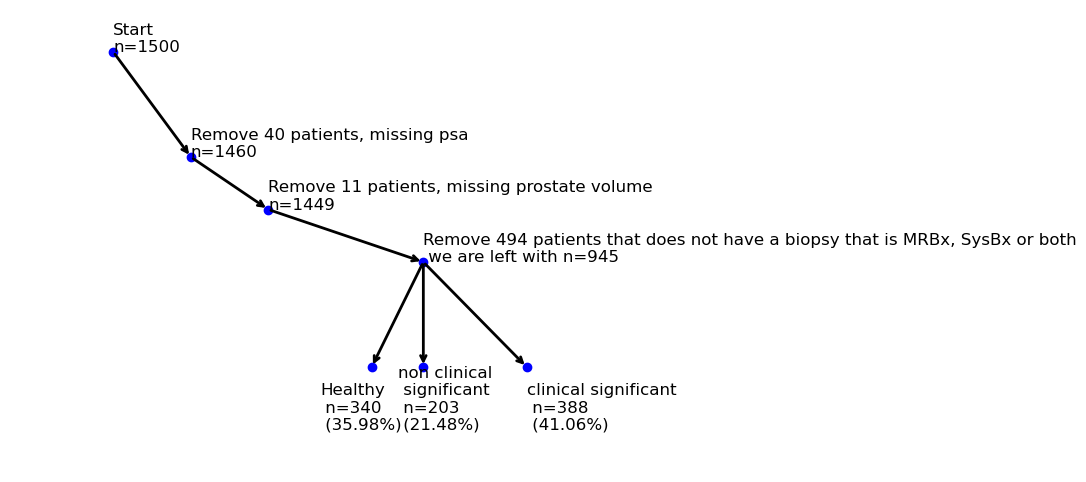

In [201]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
df_exploded = df



# Split the lesion_GS column by comma and explode the DataFrame to handle multiple scores
df['lesion_GS'] = df['lesion_GS'].str.split(',')
df_exploded = df.explode('lesion_GS').reset_index(drop=True)

# Group by patient_id and select the highest Gleason score for each patient
df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()

# Merge the highest Gleason scores back to the original DataFrame
df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')

# Calculate the counts for each category
gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]

# Print the counts
# Count total unique patients after filtering
total = df.shape[0]

# Existing counts
counted = gleason_7_low + gleason_7_high + negative_biopsy

# Unclassified
unclassified = df[~df["lesion_GS"].isin(["0+0", "3+3", "3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])]
print(f"⚠️ Unclassified patients: {unclassified.shape[0]}")
print(unclassified["lesion_GS"].value_counts(dropna=False))
print(gleason_7_low, gleason_7_high, negative_biopsy)

# Plot the results
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot([0.2, 0.35, 0.5, 0.8, 0.7, 0.8, 1], [2, 1.5, 1.25, 1, 0.5, 0.5, 0.5], 'o', color='blue')
ax.annotate("", xy=(0.35, 1.5), xytext=(0.2, 2), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.5, 1.25), xytext=(0.35, 1.5), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.8, 1), xytext=(0.5, 1.25), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.7, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(0.8, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))
ax.annotate("", xy=(1, 0.5), xytext=(0.8, 1), arrowprops=dict(arrowstyle="->", lw=2))

ax.text(0.2, 2, "Start\nn=1500", fontsize=12)
ax.text(0.35, 1.5, "Remove 40 patients, missing psa \nn=1460", fontsize=12)
ax.text(0.5, 1.25, "Remove 11 patients, missing prostate volume \nn=1449", fontsize=12)
ax.text(0.8, 1, "Remove 494 patients that does not have a biopsy that is MRBx, SysBx or both\n we are left with n=945", fontsize=12)
ax.text(0.6, 0.2, f"Healthy\n n={negative_biopsy} \n ({(negative_biopsy / 945) * 100:.2f}%)", fontsize=12)
ax.text(0.75, 0.2, f"non clinical \n significant \n n={gleason_7_low} \n ({(gleason_7_low / 945) * 100:.2f}%) " , fontsize=12)
ax.text(1, 0.2, f"clinical significant\n n={gleason_7_high} \n ({(gleason_7_high / 945) * 100:.2f}%)", fontsize=12)

ax.set_xlim(0, 1.2)
ax.set_ylim(0, 2.2)
ax.axis("off")

plt.show()

In [237]:
def median_iqr(series):
    return f"{series.median():.2f} ({series.quantile(0.25):.2f}-{series.quantile(0.75):.2f})"



def generate_summary_table(df):
    N = len(df)
    age = df['patient_age']
    psa = df['psa']
    prostate_volume = df['prostate_volume']
    psad = df['psad']
    
    age_mean_std = f"{age.mean():.2f},\u2009+-\u2009 {age.std():.2f}"
    psa_median_iqr = f"{psa.mean():2f},\u2009+-\u2009 {psa.std():.2f}"

    psad_median_iqr = f"{psad.mean():2f},\u2009+-\u2009 {psad.std():.2f}"
    prostate_volume_median_std = f"{prostate_volume.median():.2f},\u2009+-\u2009 {prostate_volume.std():.2f}"


    vol_35 = prostate_volume[prostate_volume < 35].shape[0]
    vol_35_50 = prostate_volume[(prostate_volume >= 35) & (prostate_volume < 50)].shape[0]
    vol_50 = prostate_volume[prostate_volume >= 50].shape[0]

    biopsy_counts = df['histopath_type'].value_counts()
    biopsy_types = {
        'MRBx': biopsy_counts.get('MRBx', 0),
        'SysBx': biopsy_counts.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts.get('SysBx+MRBx', 0)
    }
    df['lesion_GS'] = df['lesion_GS'].str.split(',')
    df_exploded = df.explode('lesion_GS').reset_index(drop=True)

# Group by patient_id and select the highest Gleason score for each patient
    df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()

# Merge the highest Gleason scores back to the original DataFrame
    df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')

    gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]

    table_data = {
        'Age(Years)': age_mean_std,
        'PSA(ng/ml)': psa_median_iqr,
        'PSAD(ng/ml^2)': psad_median_iqr,
        'Prostate Volume(ml)': prostate_volume_median_std,
        "< 35 mL": f"{vol_35} ({(vol_35 / len(df)) * 100:.2f}%)",
        "35 - 50 mL": f"{vol_35_50} ({(vol_35_50 / len(df)) * 100:.2f}%)",
        "> 50 mL": f"{vol_50} ({(vol_50 / len(df)) * 100:.2f}%)",
        "Biopsy type": "".join([f"{k}: {v} ({(v / len(df)) * 100:.2f}%)" for k, v in biopsy_types.items()]),
        "Biopsy results:": "",
        "Negative:": f"{negative_biopsy} ({(negative_biopsy / len(df)) * 100:.2f}%)",
        "Gleason score ≤7:": f"{gleason_7_low} ({(gleason_7_low / len(df)) * 100:.2f}%)",
        "Gleason score >7:": f"{gleason_7_high} ({(gleason_7_high / len(df)) * 100:.2f}%)",
    }
    table_df = pd.DataFrame.from_dict(table_data, orient='index', columns=[f'Patients ({N})'])
    return table_df
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
summary_table = generate_summary_table(df)
print(summary_table)


                                                        Patients (931)
Age(Years)                                             66.48, +-  7.05
PSA(ng/ml)                                        13.180301, +-  17.42
PSAD(ng/ml^2)                                       0.277683, +-  0.44
Prostate Volume(ml)                                   50.72, +-  31.39
< 35 mL                                                   192 (20.62%)
35 - 50 mL                                                245 (26.32%)
> 50 mL                                                   494 (53.06%)
Biopsy type          MRBx: 517 (55.53%)SysBx: 210 (22.56%)SysBx+MRB...
Biopsy results:                                                       
Negative:                                                 340 (36.52%)
Gleason score ≤7:                                         203 (21.80%)
Gleason score >7:                                         388 (41.68%)


In [227]:
def summarize2(df_subset):
    age = df_subset['patient_age']
    psa = df_subset['psa']
    prostate_volume = df_subset['prostate_volume']
    psad = df_subset['psad']

    vol_35 = prostate_volume[prostate_volume < 35].shape[0]
    vol_35_50 = prostate_volume[(prostate_volume >= 35) & (prostate_volume < 50)].shape[0]
    vol_50 = prostate_volume[prostate_volume >= 50].shape[0]

    biopsy_counts = df_subset['histopath_type'].value_counts()
    return {
        'Age (Years)': f"{age.mean():.2f}, ± {age.std():.2f}",
        'PSA (ng/ml)': f"{psa.mean():.2f}, ± {psa.std():.2f}",
        'PSAD (ng/ml²)': f"{psad.mean():.2f}, ± {psad.std():.2f}",
        'Prostate Volume (ml)': f"{prostate_volume.mean():.2f}, ± {prostate_volume.std():.2f}",
        "< 35 mL": f"{vol_35} ({(vol_35 / len(df_subset)) * 100:.2f}%)",
        "35–50 mL": f"{vol_35_50} ({(vol_35_50 / len(df_subset)) * 100:.2f}%)",
        "> 50 mL": f"{vol_50} ({(vol_50 / len(df_subset)) * 100:.2f}%)",
        "Biopsy Type: MRBx": f"{biopsy_counts.get('MRBx', 0)} ({(biopsy_counts.get('MRBx', 0) / len(df_subset)) * 100:.2f}%)",
        "Biopsy Type: SysBx": f"{biopsy_counts.get('SysBx', 0)} ({(biopsy_counts.get('SysBx', 0) / len(df_subset)) * 100:.2f}%)",
        "Biopsy Type: SysBx+MRBx": f"{biopsy_counts.get('SysBx+MRBx', 0)} ({(biopsy_counts.get('SysBx+MRBx', 0) / len(df_subset)) * 100:.2f}%)",
        "Negative (0+0)": f"{sum(df_subset['lesion_GS'] == '0+0')} ({(sum(df_subset['lesion_GS'] == '0+0') / len(df_subset)) * 100:.2f}%)",
        "Gleason = 3+3": f"{sum(df_subset['lesion_GS'] == '3+3')} ({(sum(df_subset['lesion_GS'] == '3+3') / len(df_subset)) * 100:.2f}%)",
        "Gleason ≥ 3+4": f"{sum(df_subset['group'] == 'csPCa')} ({(sum(df_subset['group'] == 'csPCa') / len(df_subset)) * 100:.2f}%)",
    }

def generate_summary_table2(df):
    df['lesion_GS'] = df['lesion_GS'].str.split(',')
    df_exploded = df.explode('lesion_GS').reset_index(drop=True)
    df_highest_gs = df_exploded.groupby('patient_id')['lesion_GS'].apply(
        lambda x: get_highest_gleason_score(x.tolist())
    ).reset_index()

    df = df.drop(columns=['lesion_GS']).merge(df_highest_gs, on='patient_id')

    # Define csPCa: 1 if GS is ≥ 3+4
    csPCa_scores = ["3+4", "4+3", "4+4", "5+4", "4+5", "5+5", "3+5", "5+3"]
    df['csPCa'] = df['lesion_GS'].apply(lambda x: 1 if x in csPCa_scores else 0)

    all_summary = summarize2(df)
    group0 = summarize2(df[df['csPCa'] == 0])
    group1 = summarize2(df[df['csPCa'] == 1])

    return pd.DataFrame({
        f"All Patients (N={len(df)})": all_summary,
        f"csPCa = 0 (N={(df['csPCa'] == 0).sum()})": group0,
        f"csPCa = 1 (N={(df['csPCa'] == 1).sum()})": group1
    })

df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
summary_table = generate_summary_table2(df)
print(summary_table)

KeyError: 'group'

In [229]:
def generate_four_column_summary(df):
    # Explode lesion_GS into multiple rows per patient
    df['lesion_GS'] = df['lesion_GS'].str.split(',')
    df_exploded = df.explode('lesion_GS').reset_index(drop=True)

    # Get highest Gleason score per patient
    df_highest = df_exploded.groupby('patient_id')['lesion_GS'].apply(get_highest_gleason_score).reset_index()
    df = df.drop(columns=['lesion_GS']).merge(df_highest, on='patient_id')

    df['lesion_GS'] = df['lesion_GS'].str.strip()

    # Classify based on Gleason score
    def classify_gleason(gs):
        if gs in ["3+4", "4+3", "4+4", "5+4", "4+5", "5+5", "3+5", "5+3"]:
            return 'csPCa'
        elif gs == "3+3":
            return 'non-csPCa'
        elif gs == "0+0":
            return 'negative'
        else:
            return 'other'

    df['group'] = df['lesion_GS'].apply(classify_gleason)

    df_all = df
    df_csPCa = df[df['group'] == 'csPCa']
    df_non_csPCa = df[df['group'] == 'non-csPCa']
    df_negative = df[df['group'] == 'negative']

    # Generate summaries

    cs_summary = summarize2(df_csPCa)
    non_cs_summary = summarize2(df_non_csPCa)
    neg_summary = summarize2(df_negative)

    return pd.DataFrame({
        f"Clinically Significant (N={len(df_csPCa)})": cs_summary,
        f"Non-significant (3+3) (N={len(df_non_csPCa)})": non_cs_summary,
        f"Negative (0+0) (N={len(df_negative)})": neg_summary
    })

# Usage
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
summary_table = generate_four_column_summary(df)
print(summary_table)

                        Clinically Significant (N=388)  \
Age (Years)                              67.83, ± 6.89   
PSA (ng/ml)                             16.26, ± 21.32   
PSAD (ng/ml²)                             0.36, ± 0.53   
Prostate Volume (ml)                    53.41, ± 27.29   
< 35 mL                                    95 (24.48%)   
35–50 mL                                  113 (29.12%)   
> 50 mL                                   180 (46.39%)   
Biopsy Type: MRBx                         236 (60.82%)   
Biopsy Type: SysBx                         47 (12.11%)   
Biopsy Type: SysBx+MRBx                   105 (27.06%)   
Negative (0+0)                               0 (0.00%)   
Gleason = 3+3                                0 (0.00%)   
Gleason ≥ 3+4                            388 (100.00%)   

                        Non-significant (3+3) (N=203) Negative (0+0) (N=340)  
Age (Years)                             67.56, ± 6.53          64.29, ± 7.02  
PSA (ng/ml)                  

In [219]:
marksheet_df = pd.read_csv(marksheet_path)
Preprocessed_marksheet_df, combined_ids = preprocess_data(marksheet_df)

fileInfoT2w = '_t2w.mha'

fileInfo = '.nii.gz'
t2w_paths = find_t2W_files(source_PI_CAI, combined_ids, fileInfoT2w)
Guerbet23_nii_gz_paths = find_t2W_files(source_PI_CAI_whole_gland_Guerbet23, combined_ids, fileInfo)
Human_nii_gz_paths = find_t2W_files(source_PI_CAI_Human, combined_ids, fileInfo)

Initial dataset length: 1500
Dataset length after dropping rows with missing psa: 1460
Dataset length after dropping rows with missing prostate volume: 1439
Dataset length after filtering gleason scores: 956
Dataset length after filtering biopsies: 931


In [91]:
t2w_patient_ids = [path.split('\\')[-2] for path in t2w_paths]
Guerbet23_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Guerbet23_nii_gz_paths]
Human_nii_gz_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Human_nii_gz_paths]

t2w_df = pd.DataFrame({'patient_id': t2w_patient_ids, 'T2w_path': t2w_paths})
Guerbet23_df = pd.DataFrame({'Nii_gz_path': Guerbet23_nii_gz_paths, 'patient_id': Guerbet23_patient_ids})
Human_df = pd.DataFrame({'Nii_gz_path': Human_nii_gz_paths, 'patient_id': Human_nii_gz_patient_ids})

df_path_merged_Guerbet23 = pd.merge(t2w_df, Guerbet23_df, on='patient_id')
df_path_merged_Human = pd.merge(t2w_df, Human_df, on='patient_id')


Image shape: (31, 640, 640)


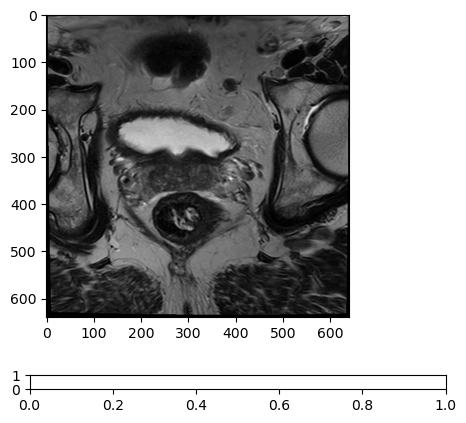

In [92]:
file_path = r"Data\picai_public_images\picai_public_images_fold0\10000\10000_1000000_t2w.mha"
image = sitk.ReadImage(file_path)
image_data = sitk.GetArrayFromImage(image)

print(f"Image shape: {image_data.shape}")

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.25)

axlayer = plt.axes([0.25, 0.1, 0.65, 0.03])

ax.imshow(image_data[18, :, :], cmap='gray')

plt.show()

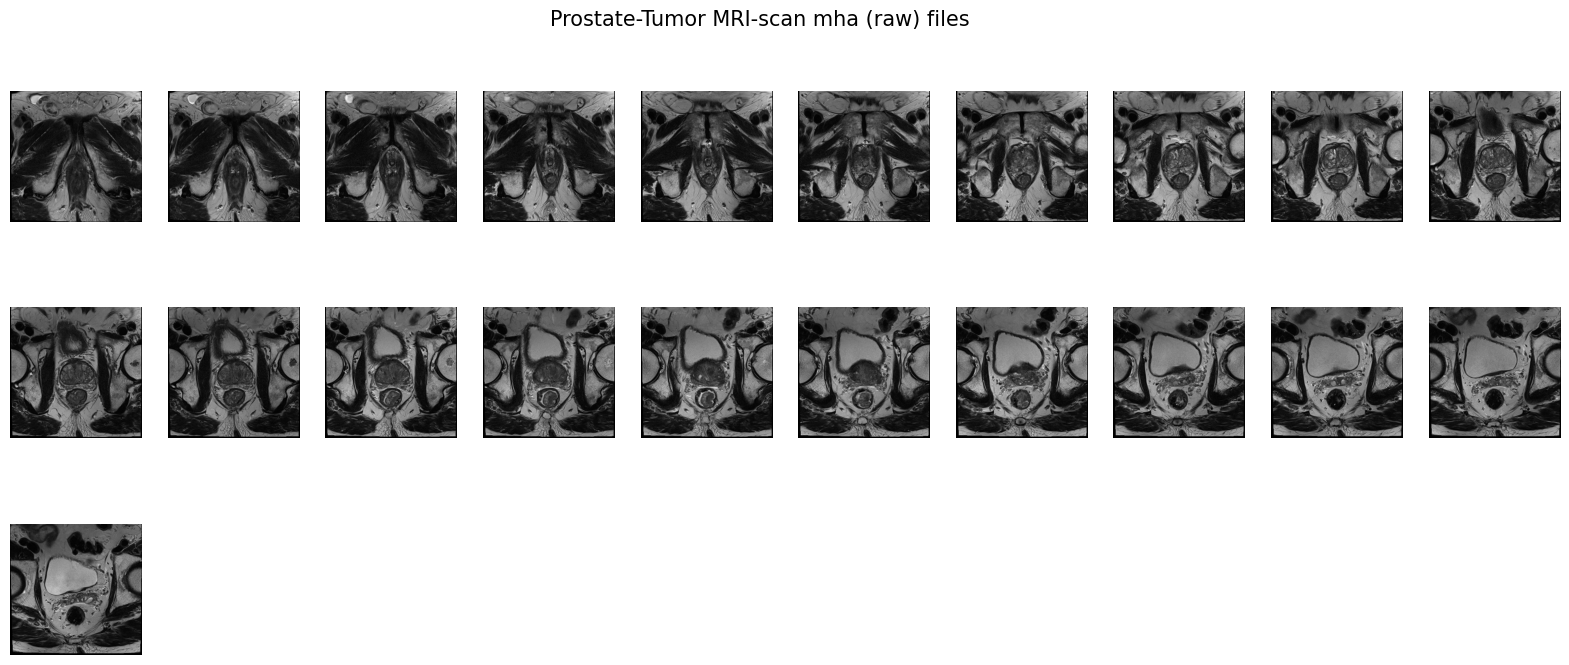

In [17]:
file_path = r"Data\picai_public_images\picai_public_images_fold1\10008\10008_1000008_t2w.mha"
image = sitk.ReadImage(file_path)
image_data = sitk.GetArrayFromImage(image)

if image_data.max() > 0:
    image_data = image_data / image_data.max()

num_slices = image_data.shape[0]

cols = 10
rows = int(np.ceil(num_slices / cols))

plt.figure(figsize=(20, rows * 2.5))
plt.gray()
plt.subplots_adjust(hspace=0.5)

for i in range(num_slices):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(image_data[i], cmap='gray')
    plt.axis('off')

plt.suptitle('Prostate-Tumor MRI-scan mha (raw) files', size=15)
plt.show()

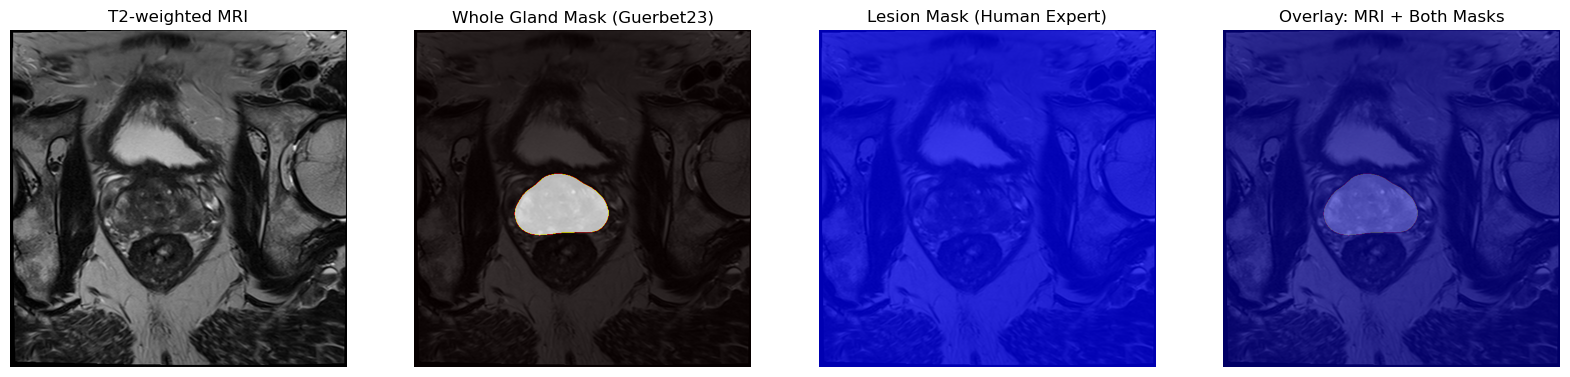

In [93]:
def load_nifti_image(file_path):
    img = sitk.ReadImage(file_path)
    return sitk.GetArrayFromImage(img) 

patient_id = df_path_merged_Guerbet23.iloc[0]['patient_id']  

t2w_path = df_path_merged_Guerbet23.iloc[0]['T2w_path']
guerbet23_mask_path = df_path_merged_Guerbet23.iloc[0]['Nii_gz_path']
human_mask_path = df_path_merged_Human.iloc[0]['Nii_gz_path']

t2w_image = load_nifti_image(t2w_path)
guerbet23_mask = load_nifti_image(guerbet23_mask_path)
human_mask = load_nifti_image(human_mask_path) 

t2w_image = t2w_image / np.max(t2w_image)

mid_slice = t2w_image.shape[0] // 2

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

ax[0].imshow(t2w_image[mid_slice], cmap='gray')
ax[0].set_title("T2-weighted MRI")

ax[1].imshow(t2w_image[mid_slice], cmap='gray')
ax[1].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.7)
ax[1].set_title("Whole Gland Mask (Guerbet23)")

ax[2].imshow(t2w_image[mid_slice], cmap='gray')
ax[2].imshow(human_mask[mid_slice], cmap='winter', alpha=0.7)
ax[2].set_title("Lesion Mask (Human Expert)")

ax[3].imshow(t2w_image[mid_slice], cmap='gray')
ax[3].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.4)
ax[3].imshow(human_mask[mid_slice], cmap='winter', alpha=0.4)
ax[3].set_title("Overlay: MRI + Both Masks")

for a in ax:
    a.axis("off")

plt.show()

In [235]:
def find_significant_correlations(df, processed_subset, target_variable='case_csPCa', threshold=0.0):
    df['patient_id'] = df['patient_id'].astype(int)

    merge_df = pd.merge(processed_subset, df, left_on='patient_id', right_on='patient_id', how='left')
    merge_df.drop('patient_id', axis=1, inplace=True)
    correlation_matrix = merge_df.corr()
    absolute_correlation = correlation_matrix[target_variable].abs()
    significant_correlations = absolute_correlation[absolute_correlation > threshold].sort_values(ascending=False)
    significant_correlations_sorted = significant_correlations[significant_correlations.index != target_variable]
    significant_correlations_df = significant_correlations_sorted.reset_index()
    significant_correlations_df.columns = ['Feature', 'Correlation with '+target_variable]

    return significant_correlations_df


def evaluate_model_perfomance(model, X_train, y_train, X_test, y_test, name=""):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]

    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
    auc_score = auc(fpr, tpr)

    classification_report_str = classification_report(y_test, y_test_pred)

    metrics = {
        f'AUC_{name}': auc_score,
        f'Accuracy_{name}': test_accuracy,
        f'Sensitivity_{name}': recall_score(y_test, y_test_pred),
        f'Specificity_{name}': recall_score(y_test, y_test_pred, pos_label=0),
        f'F! Score_{name}': f1_score(y_test, y_test_pred),
    }

    return train_accuracy, test_accuracy, classification_report_str, metrics, fpr, tpr

def print_mean_and_std(results_df):
    for i, row in results_df.iterrows():
        model_name = row['model']

        print(f"Model: {model_name}")
        print("Cross-validation metrics (Mean, Standard Deviation):")

        metrics = ['AUC', 'Accuracy', 'Sensitivity', 'Precision', 'F1 Score']
        for metric in metrics:
            mean_val, sd_val = row[metric]
            print(f"{metric}: Mean = {mean_val:.4f}, SD = {sd_val:.4f}")
        print("\n--------------------------------------------------")

    return results_df[['model'] + metrics]

def evaluate_confusion_matrix(model, X_test, y_test, ax=None, name="", threshold=0.5, display= True):

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    if ax is not None:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(ax=ax)
        ax.set_title(name)
    
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0.0

    metrics = {
        'Title:': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'TP': TP,
        'TN': TN,
        'FP': FP,
        'FN': FN
    }
    mse = mean_squared_error(y_test, y_pred_proba)
    r2 = r2_score(y_test, y_pred_proba)
    

    if display:
        print(f'Title: {name}')
        print(f'Accuracy: {accuracy:.4f}')
        print(f'Precision: {precision:.4f}')
        print(f'Recall: {recall:.4f}')
        print(f'F1 Score: {f1:.4f}')
        print(f"R2 Score: {r2}")
        print(f"Mean Squared Error: {mse}")
        print('----------------------------')

    return metrics, cm

def apply_scaling(scale='range'):
    if scale == 'outliers':
        scaler = RobustScaler()
    elif scale == 'range':
        scaler = MinMaxScaler()
    elif scale == 'non-gaussian':
        scaler = PowerTransformer()
    elif scale == 'sparse':
        scaler = MaxAbsScaler()
    elif scale == 'none':
        scaler = None  # No scaling
    else:
        scaler = StandardScaler()  # Default scaler

    return scaler

def generate_summary_table_train_test(df, X_train, X_test):
    N = len(df)
    age = df['patient_age']
    age_train = X_train['patient_age']
    age_test = X_test['patient_age']
    psa = df['psa']
    psa_train = X_train['psa']
    psa_test = X_test['psa']
    prostate_volume = df['prostate_volume']
    prostate_volume_train = X_train['prostate_volume']
    prostate_volume_test = X_test['prostate_volume']
    psad = df['psad']
    psad_train = X_train['psad']
    psad_test = X_test['psad']
    
    age_mean_std = f"{age.mean():.2f},\u2009+-\u2009 {age.std():.2f}"
    age_train_mean_std = f"{age_train.mean():.2f},\u2009+-\u2009 {age_train.std():.2f}"
    age_test_mean_std = f"{age_test.mean():.2f},\u2009+-\u2009 {age_test.std():.2f}"
    psa_median_iqr = f"{psa.mean():.2f},\u2009+-\u2009 {psa.std():.2f}"
    psa_train_median_iqr = f"{psa_train.mean():.2f},\u2009+-\u2009 {psa_train.std():.2f}"
    psa_test_median_iqr = f"{psa_test.mean():.2f},\u2009+-\u2009 {psa_test.std():.2f}"
    psad_median_iqr = f"{psad.mean():.2f},\u2009+-\u2009 {psad.std():.2f}"
    psad_train_median_iqr = f"{psad_train.mean():.2f},\u2009+-\u2009 {psad_train.std():.2f}"
    psad_test_median_iqr = f"{psad_test.mean():.2f},\u2009+-\u2009 {psad_test.std():.2f}"
    prostate_volume_median_std = f"{prostate_volume.mean():.2f},\u2009+-\u2009 {prostate_volume.std():.2f}"
    prostate_volume_train_median_std = f"{prostate_volume_train.mean():.2f},\u2009+-\u2009 {prostate_volume_train.std():.2f}"
    prostate_volume_test_median_std = f"{prostate_volume_test.mean():.2f},\u2009+-\u2009 {prostate_volume_test.std():.2f}"


    vol_35 = prostate_volume[prostate_volume < 35].shape[0]
    vol_35_train = prostate_volume_train[prostate_volume_train < 35].shape[0]
    vol_35_test = prostate_volume_test[prostate_volume_test < 35].shape[0]
    vol_35_50 = prostate_volume[(prostate_volume >= 35) & (prostate_volume < 50)].shape[0]
    vol_35_50_train = prostate_volume_train[(prostate_volume_train >= 35) & (prostate_volume_train < 50)].shape[0]
    vol_35_50_test = prostate_volume_test[(prostate_volume_test >= 35) & (prostate_volume_test < 50)].shape[0]
    vol_50 = prostate_volume[prostate_volume >= 50].shape[0]
    vol_50_train = prostate_volume_train[prostate_volume_train >= 50].shape[0]
    vol_50_test = prostate_volume_test[prostate_volume_test >= 50].shape[0]

    biopsy_counts = df['histopath_type'].value_counts()
    biopsy_counts_train = X_train['histopath_type'].value_counts()
    biopsy_counts_test = X_test['histopath_type'].value_counts()
    biopsy_types = {
        'MRBx': biopsy_counts.get('MRBx', 0),
        'SysBx': biopsy_counts.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts.get('SysBx+MRBx', 0)
    }
    biopsy_types_train = {
        'MRBx': biopsy_counts_train.get('MRBx', 0),
        'SysBx': biopsy_counts_train.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts_train.get('SysBx+MRBx', 0)
    }
    biopsy_types_test = {
        'MRBx': biopsy_counts_test.get('MRBx', 0),
        'SysBx': biopsy_counts_test.get('SysBx', 0),
        'SysBx+MRBx': biopsy_counts_test.get('SysBx+MRBx', 0)
    }
    test_df = X_test
    train_df = X_train

    df['lesion_GS'] = df['lesion_GS'].str.split(',')
    train_df['lesion_GS'] = train_df['lesion_GS'].str.split(',')
    test_df['lesion_GS'] = test_df['lesion_GS'].str.split(',')

    df_exploded = df.explode('lesion_GS').reset_index(drop=True)
    train_df_exploded = train_df.explode('lesion_GS').reset_index(drop=True)
    test_df_exploded = test_df.explode('lesion_GS').reset_index(drop=True)

    df_highest_gleason = df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()
    train_df_highest_gleason = train_df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()
    test_df_highest_gleason = test_df_exploded.groupby('patient_id')['lesion_GS'].apply(lambda x: get_highest_gleason_score(x)).reset_index()

    df = df.drop(columns=['lesion_GS']).merge(df_highest_gleason, on='patient_id')
    train_df = train_df.drop(columns=['lesion_GS']).merge(train_df_highest_gleason, on='patient_id')
    test_df = test_df.drop(columns=['lesion_GS']).merge(test_df_highest_gleason, on='patient_id')

    gleason_7_low = df[df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_low_train = train_df[train_df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_low_test = test_df[test_df["lesion_GS"] == "3+3"].shape[0]
    gleason_7_high = df[df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    gleason_7_high_train = train_df[train_df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    gleason_7_high_test = test_df[test_df["lesion_GS"].isin(["3+4", "4+3", "4+4", "5+4", "4+5", "5+5"])].shape[0]
    negative_biopsy = df[df["lesion_GS"] == "0+0"].shape[0]
    negative_biopsy_train = train_df[train_df["lesion_GS"] == "0+0"].shape[0]
    negative_biopsy_test = test_df[test_df["lesion_GS"] == "0+0"].shape[0]

    table_data = {
        'Age(Years)': [age_mean_std, age_train_mean_std, age_test_mean_std],
        'PSA(ng/ml)': [psa_median_iqr, psa_train_median_iqr, psa_test_median_iqr],
        'PSAD(ng/ml^2)': [psad_median_iqr, psad_train_median_iqr, psad_test_median_iqr],
        'Prostate Volume(ml)': [prostate_volume_median_std, prostate_volume_train_median_std, prostate_volume_test_median_std],
        "< 35 mL": [f"{vol_35} ({(vol_35 / len(df)) * 100:.2f}%)", f"{vol_35_train} ({(vol_35_train / len(X_train)) * 100:.2f}%)", f"{vol_35_test} ({(vol_35_test / len(X_test)) * 100:.2f}%)"],
        "35 - 50 mL": [f"{vol_35_50} ({(vol_35_50 / len(df)) * 100:.2f}%)", f"{vol_35_50_train} ({(vol_35_50_train / len(X_train)) * 100:.2f}%)", f"{vol_35_50_test} ({(vol_35_50_test / len(X_test)) * 100:.2f}%)"],
        "> 50 mL": [f"{vol_50} ({(vol_50 / len(df)) * 100:.2f}%)", f"{vol_50_train} ({(vol_50_train / len(X_train)) * 100:.2f}%)", f"{vol_50_test} ({(vol_50_test / len(X_test)) * 100:.2f}%)"],
        "Biopsy type": ["".join([f"{k}: {v} ({(v / len(df)) * 100:.2f}%)" for k, v in biopsy_types.items()]), "".join([f"{k}: {v} ({(v / len(X_train)) * 100:.2f}%)" for k, v in biopsy_types_train.items()]), "".join([f"{k}: {v} ({(v / len(X_test)) * 100:.2f}%)" for k, v in biopsy_types_test.items()]),
        ],
        "Biopsy results:": "",
        "Negative:": [f"{negative_biopsy} ({(negative_biopsy / len(df)) * 100:.2f}%)", f"{negative_biopsy_train} ({(negative_biopsy_train / len(X_train)) * 100:.2f}%)", f"{negative_biopsy_test} ({(negative_biopsy_test / len(X_test)) * 100:.2f}%)"],
        "Gleason score ≤7:": [f"{gleason_7_low} ({(gleason_7_low / len(df)) * 100:.2f}%)", f"{gleason_7_low_train} ({(gleason_7_low_train / len(X_train)) * 100:.2f}%)", f"{gleason_7_low_test} ({(gleason_7_low_test / len(X_test)) * 100:.2f}%)"],
        "Gleason score >7:": [f"{gleason_7_high} ({(gleason_7_high / len(df)) * 100:.2f}%)", f"{gleason_7_high_train} ({(gleason_7_high_train / len(X_train)) * 100:.2f}%)", f"{gleason_7_high_test} ({(gleason_7_high_test / len(X_test)) * 100:.2f}%)"],
    }

    table_df = pd.DataFrame.from_dict(table_data,  orient='index', columns=[f'Patients ({N})', 'Train','Test'])
    return table_df

In [22]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
df2 = df.select_dtypes(include=['int32', 'int64', 'float64'])
df2['case_csPCa'] = df['case_csPCa']
df2_subset = df2[['patient_id', 'case_csPCa']]

df2 = df2.drop('case_csPCa', axis=1)

correlations_df2 = find_significant_correlations(df2, df2_subset, 'case_csPCa', threshold=0.01)
correlations_df2

,Feature,Correlation with case_csPCa
0,case_ISUP,0.827689
1,psad,0.169394
2,patient_age,0.154934
3,psa,0.148053
4,prostate_volume,0.145431
5,study_id,0.054117


In [242]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')


# Split the data into train and test sets
X = df.drop(columns=['case_csPCa'])
y = df['case_csPCa']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)



df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
summary_table = generate_summary_table_train_test(df, X_train, X_test)
print(summary_table)

                                                        Patients (931)  \
Age(Years)                                             66.48, +-  7.05   
PSA(ng/ml)                                            13.18, +-  17.42   
PSAD(ng/ml^2)                                           0.28, +-  0.44   
Prostate Volume(ml)                                   58.28, +-  31.39   
< 35 mL                                                   192 (20.62%)   
35 - 50 mL                                                245 (26.32%)   
> 50 mL                                                   494 (53.06%)   
Biopsy type          MRBx: 517 (55.53%)SysBx: 210 (22.56%)SysBx+MRB...   
Biopsy results:                                                   None   
Negative:                                                 340 (36.52%)   
Gleason score ≤7:                                         203 (21.80%)   
Gleason score >7:                                         388 (41.68%)   

                                     

In [29]:
df = pd.read_csv('Data/Preprocessed_marksheet_all.csv')
params = ['patient_age', 'psa', 'prostate_volume']
#df_subset = df[['patient_id', 'case_csPCa']]
#correlation_df = find_significant_correlations(df, df_subset, 'case_csPCa', threshold=0.18)
Y = df['case_csPCa']
# X1_train, X1_test, y1_train, y1_test, X1_train_ids, X1_test_ids_split = train_test_split(
#     training_df, Y, training_ids, test_size=0.3, random_state=42, stratify=Y)
scaler = apply_scaling('range')


X_simple = df[params]
X2_train, X2_test, y2_train, y2_test= train_test_split(X_simple, Y, test_size=0.3, random_state=42, stratify=Y)

if scaler is not None:
    X2_simple_train_scaled = scaler.fit_transform(X2_train)
    X2_simple_test_scaled = scaler.transform(X2_test)
else:
    X2_simple_train_scaled = X2_train
    X2_simple_test_scaled = X2_test

Log_model = LogisticRegression()
SVC_model = SVC(probability=True)
Tree_model = DecisionTreeClassifier()
Forest_model = RandomForestClassifier()
Kneighbor_model = KNeighborsClassifier()
Gaussian_model = GaussianNB()

Log_model.fit(X2_simple_train_scaled, y2_train)
SVC_model.fit(X2_simple_train_scaled, y2_train)
Tree_model.fit(X2_simple_train_scaled, y2_train)
Forest_model.fit(X2_simple_train_scaled, y2_train)
Kneighbor_model.fit(X2_simple_train_scaled, y2_train)
Gaussian_model.fit(X2_simple_train_scaled, y2_train)

y_pred_prob_simple = Log_model.predict_proba(X2_test)[:, 1]
y_pred_prob_SVC = SVC_model.predict_proba(X2_test)[:, 1]
y_pred_prob_Tree = Tree_model.predict_proba(X2_test)[:, 1]
y_pred_prob_Forest = Forest_model.predict_proba(X2_test)[:, 1]
y_pred_prob_Kneighbor = Kneighbor_model.predict_proba(X2_test)[:, 1]
y_pred_prob_Gaussian = Gaussian_model.predict_proba(X2_test)[:, 1]

d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
d:\ProgramFiles\miniconda3\envs\bachelor\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
d:\Pr

In [30]:

train_accuracy, test_accuracy, classification_report_str, metrics, fpr, tpr = evaluate_model_perfomance(Log_model, X2_simple_train_scaled, y2_train, X2_simple_test_scaled, y2_test, name="Logistic Regression Model")

metrics1, cm1 = evaluate_confusion_matrix(Log_model, X2_simple_test_scaled, y2_test, name="Logistic Regression Model", threshold=0.5, display=True)
metrics2, cm2 = evaluate_confusion_matrix(SVC_model, X2_simple_test_scaled, y2_test, name="SVC Model", threshold=0.5, display=True)
metrics3, cm3 = evaluate_confusion_matrix(Tree_model, X2_simple_test_scaled, y2_test, name="Tree Model", threshold=0.5, display=True)
metrics4, cm4 = evaluate_confusion_matrix(Forest_model, X2_simple_test_scaled, y2_test, name="Forest Model", threshold=0.5, display=True)
metrics5, cm5 = evaluate_confusion_matrix(Kneighbor_model, X2_simple_test_scaled, y2_test, name="KNeighbor Model", threshold=0.5, display=True)
metrics6, cm6 = evaluate_confusion_matrix(Gaussian_model, X2_simple_test_scaled, y2_test, name="Gaussian Model", threshold=0.5, display=True)

Title: Logistic Regression Model
Accuracy: 0.6127
Precision: 0.6000
Recall: 0.2034
F1 Score: 0.3038
R2 Score: 0.07912240119612834
Mean Squared Error: 0.22364300740639553
----------------------------
Title: SVC Model
Accuracy: 0.6408
Precision: 0.6429
Recall: 0.3051
F1 Score: 0.4138
R2 Score: 0.09252995412206944
Mean Squared Error: 0.22038686841223099
----------------------------
Title: Tree Model
Accuracy: 0.5528
Precision: 0.4602
Recall: 0.4407
F1 Score: 0.4502
R2 Score: -0.8413314274045336
Mean Squared Error: 0.4471830985915493
----------------------------
Title: Forest Model
Accuracy: 0.5880
Precision: 0.5049
Recall: 0.4407
F1 Score: 0.4706
R2 Score: -0.046550455153949066
Mean Squared Error: 0.2541637363067292
----------------------------
Title: KNeighbor Model
Accuracy: 0.6092
Precision: 0.5368
Recall: 0.4322
F1 Score: 0.4789
R2 Score: -0.08450071472330012
Mean Squared Error: 0.2633802816901409
----------------------------
Title: Gaussian Model
Accuracy: 0.5986
Precision: 0.6000
Re

In [105]:
NEW_SPACING = (0.5, 0.5, 3.0)
def resample_image(image, new_spacing):
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()


    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(original_size)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetTransform(sitk.Transform())
    resampler.SetInterpolator(sitk.sitkLinear)

    return resampler.Execute(image)

def normalize_image(image):
    image = sitk.Cast(image, sitk.sitkFloat32)
    min_intensity = sitk.GetArrayFromImage(image).min()
    max_intensity = sitk.GetArrayFromImage(image).max()
    normalize_image = (image - min_intensity) / (max_intensity - min_intensity)
    return normalize_image


def process_mha_files(t2w_folder, output_folder):
    """Processes all .mha files in the input folder and saves resampled versions."""
    if not os.path.exists(t2w_folder):
        print(f"ERROR: Input folder does not exist! Check path: {t2w_folder}")
        return
    
    os.makedirs(output_folder, exist_ok=True)
    
    patient_folders = [os.path.join(t2w_folder, d) for d in os.listdir(t2w_folder) if os.path.isdir(os.path.join(t2w_folder, d))]
    print(f"Total patient folders found: {len(patient_folders)}")

    total_processed = 0
    
    for patient_folder in patient_folders:
        patient_id = os.path.basename(patient_folder)
        print(f"\n🔍 Checking folder: {patient_folder}")
        actual_files = os.listdir(patient_folder)
        print(f"Files found: {actual_files}")
        
        t2w_files = [f for f in actual_files if f.endswith("_t2w.mha")]
        if not t2w_files:
            print(f"⚠️ No _t2w.mha file found in {patient_folder} (Skipping)")
            continue

        t2w_path = os.path.join(patient_folder, t2w_files[0])
        print(f"Processing: {t2w_path}")
        study_id = t2w_files[0].split('_')[1]
        output_path = os.path.join(output_folder, f"{patient_id}_{study_id}_t2w_resampled.mha")
        print(f"Processing {t2w_path}...")

        try:
            image = sitk.ReadImage(t2w_path)
            resampled_image = resample_image(image, NEW_SPACING)
            normalized_image = normalize_image(resampled_image)
            sitk.WriteImage(normalized_image, output_path)
            print(f"Saved resampled image to {output_path}")
            total_processed += 1
        except Exception as e:
            print(f"ERROR processing {patient_id}: {e}")

    print(f"Processing complete. Total images resampled: {total_processed}")

def process_mask_files(input_folder, output_folder):
    """Processes all .mha files in the input folder and saves resampled versions."""
    if not os.path.exists(input_folder):
        print(f"ERROR: Input folder does not exist! Check path: {input_folder}")
        return
    
    os.makedirs(output_folder, exist_ok=True)
    

    total_processed = 0
    
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.nii.gz'):
            input_path = os.path.join(input_folder, file_name)
            print(f"\n🔍 Checking folder: {input_path}")

            patient_id, study_id = file_name.split('_')[:2]
            output_path = os.path.join(output_folder, f"{patient_id}_{study_id}")
            print(f"Processing: {file_name}")

            try:
                image = sitk.ReadImage(input_path)
                resampled_image = resample_image(image, NEW_SPACING)
                normalized_image = normalize_image(resampled_image)
                sitk.WriteImage(normalized_image, output_path)
                print(f"Saved resampled image to {output_path}")
                total_processed += 1
            except Exception as e:
                print(f"ERROR processing {file_name}: {e}")

    print(f"Processing complete. Total images resampled: {total_processed}")


In [106]:

t2w_folder0 = r"Data\picai_public_images\picai_public_images_fold0"
t2w_folder1 = r"Data\picai_public_images\picai_public_images_fold1"
t2w_folder2 = r"Data\picai_public_images\picai_public_images_fold2"
t2w_folder3 = r"Data\picai_public_images\picai_public_images_fold3"
t2w_folder4 = r"Data\picai_public_images\picai_public_images_fold4"
output_folder0 = r"Data\t2w_spacing_resampled2\resampled0"
output_folder1 = r"Data\t2w_spacing_resampled2\resampled1"
output_folder2 = r"Data\t2w_spacing_resampled2\resampled2"
output_folder3 = r"Data\t2w_spacing_resampled2\resampled3"
output_folder4 = r"Data\t2w_spacing_resampled2\resampled4"
process_mha_files(t2w_folder0, output_folder0)
process_mha_files(t2w_folder1, output_folder1)
process_mha_files(t2w_folder2, output_folder2)
process_mha_files(t2w_folder3, output_folder3)
process_mha_files(t2w_folder4, output_folder4)

Total patient folders found: 295

🔍 Checking folder: Data\picai_public_images\picai_public_images_fold0\10000
Files found: ['10000_1000000_adc.mha', '10000_1000000_cor.mha', '10000_1000000_hbv.mha', '10000_1000000_sag.mha', '10000_1000000_t2w.mha']
Processing: Data\picai_public_images\picai_public_images_fold0\10000\10000_1000000_t2w.mha
Processing Data\picai_public_images\picai_public_images_fold0\10000\10000_1000000_t2w.mha...
Saved resampled image to Data\t2w_spacing_resampled2\resampled0\10000_1000000_t2w_resampled.mha

🔍 Checking folder: Data\picai_public_images\picai_public_images_fold0\10001
Files found: ['10001_1000001_adc.mha', '10001_1000001_cor.mha', '10001_1000001_hbv.mha', '10001_1000001_sag.mha', '10001_1000001_t2w.mha']
Processing: Data\picai_public_images\picai_public_images_fold0\10001\10001_1000001_t2w.mha
Processing Data\picai_public_images\picai_public_images_fold0\10001\10001_1000001_t2w.mha...
Saved resampled image to Data\t2w_spacing_resampled2\resampled0\10001_1

In [107]:
Guerbet_23_resampled = r"Data\Guerbet23_resampled2"
Human_resampled = r"Data\Human_resampled"

process_mask_files(source_PI_CAI_whole_gland_Guerbet23, Guerbet_23_resampled)
#process_mask_files(source_PI_CAI_Human, Human_resampled)


🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10000_1000000.nii.gz
Processing: 10000_1000000.nii.gz
Saved resampled image to Data\Guerbet23_resampled2\10000_1000000.nii.gz

🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10001_1000001.nii.gz
Processing: 10001_1000001.nii.gz
Saved resampled image to Data\Guerbet23_resampled2\10001_1000001.nii.gz

🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10002_1000002.nii.gz
Processing: 10002_1000002.nii.gz
Saved resampled image to Data\Guerbet23_resampled2\10002_1000002.nii.gz

🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10003_1000003.nii.gz
Processing: 10003_1000003.nii.gz
Saved resampled image to Data\Guerbet23_resampled2\10003_1000003.nii.gz

🔍 Checking folder: Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23\10004_1000004.nii.gz
Proce

In [152]:
def print_image_spacing(resampled_folder):
    """Print the spacing of each image in the given folder."""
    
    if not os.path.exists(resampled_folder):
        print(f"ERROR: Folder {resampled_folder} does not exist!")
        return

    mha_files = [f for f in os.listdir(resampled_folder) if f.endswith('.mha')]
    print(f"Found {len(mha_files)} .mha files in the folder.")

    for filename in mha_files:
        file_path = os.path.join(resampled_folder, filename)
        
        image = sitk.ReadImage(file_path)
        
        spacing = image.GetSpacing() 
        
        print(f"File: {filename}, Spacing: {spacing}")

resampled_folder0 = r"Data\t2w_spacing_resampled\resampled0"
resampled_folder1 = r"Data\t2w_spacing_resampled\resampled1"

print_image_spacing(resampled_folder0)
print_image_spacing(resampled_folder1)

Found 295 .mha files in the folder.
File: 10000_1000000_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10001_1000001_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10003_1000003_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10006_1000006_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10017_1000017_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)
File: 10020_1000020_t2w_resampled.mha, Spacing: (0.5, 0.5, 3.0)


KeyboardInterrupt: 

In [4]:
def check_processed_images(output_folder, expected_spacing):
    """
    Check if the images in the output folder have been correctly resampled and normalized.
    """
    if not os.path.exists(output_folder):
        print(f"ERROR: Output folder does not exist! Check path: {output_folder}")
        return
    
    processed_files = [f for f in os.listdir(output_folder) if f.endswith(".mha")]
    if not processed_files:
        print(f"No processed files found in {output_folder}")
        return
    
    for file in processed_files:
        file_path = os.path.join(output_folder, file)
        image = sitk.ReadImage(file_path)
        
        # Check spacing
        spacing = image.GetSpacing()
        if spacing != expected_spacing:
            print(f"ERROR: Image {file} has incorrect spacing: {spacing}")
        else:
            print(f"Image {file} has correct spacing: {spacing}")
        
        # Check intensity range
        array = sitk.GetArrayFromImage(image)
        min_intensity = array.min()
        max_intensity = array.max()
        if min_intensity < 0 or max_intensity > 1:
            print(f"ERROR: Image {file} has incorrect intensity range: [{min_intensity}, {max_intensity}]")
        else:
            print(f"Image {file} has correct intensity range: [{min_intensity}, {max_intensity}]")

# Example usage
output_folder0 = r"Data\t2w_spacing_resampled\resampled0"
expected_spacing = (0.5, 0.5, 3.0)
check_processed_images(output_folder0, expected_spacing)

Image 10000_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10000_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10001_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10001_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10003_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10003_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10006_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10006_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10017_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10017_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10020_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10020_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10022_t2w_resampled.mha has correct spacing: (0.5, 0.5, 3.0)
Image 10022_t2w_resampled.mha has correct intensity range: [0.0, 1.0]
Image 10023_t2w_resampled.mha has correct

Image shape: (31, 640, 640)
Resampled image shape: (34, 360, 360)
Original spacing: (0.28125, 0.28125, 3.2999999825580133)
Resampled spacing: (0.5, 0.5, 3.0)
Intensity range: [0, 1708]
Resampled intensity range: [0.0, 1.0]


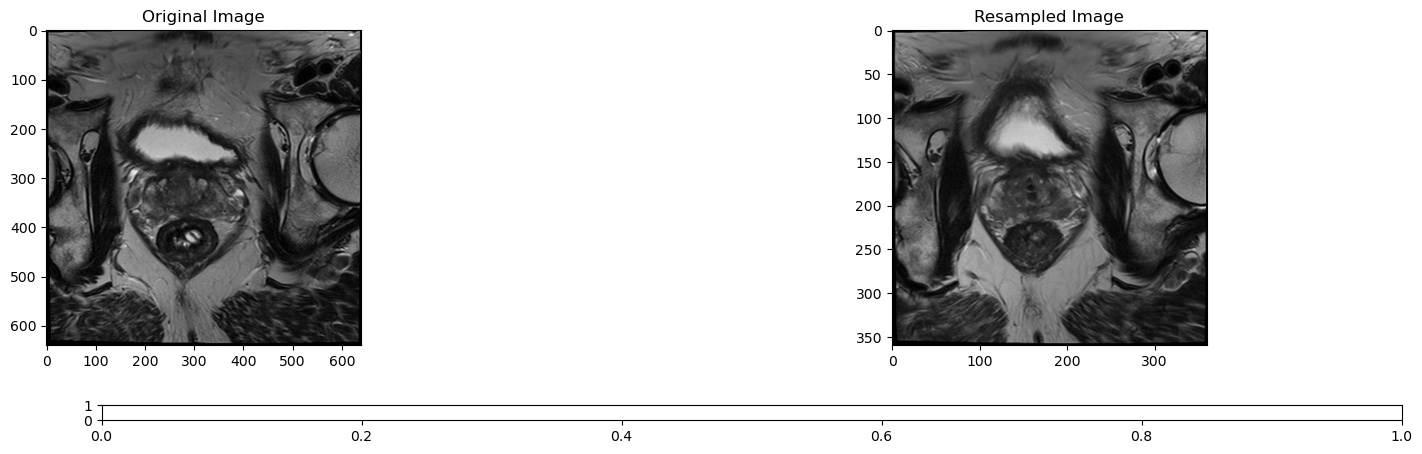

In [31]:
file_path_raw = r"Data\picai_public_images\picai_public_images_fold0\10000\10000_1000000_t2w.mha"
file_path_resampled = r"Data\t2w_spacing_resampled\resampled0\10000_1000000_t2w_resampled.mha"
image_raw = sitk.ReadImage(file_path_raw)
image_resampled = sitk.ReadImage(file_path_resampled)
image_data_raw = sitk.GetArrayFromImage(image_raw)
image_data_resampled = sitk.GetArrayFromImage(image_resampled)

print(f"Image shape: {image_data_raw.shape}")
print(f"Resampled image shape: {image_data_resampled.shape}")
print(f"Original spacing: {image_raw.GetSpacing()}")
print(f"Resampled spacing: {image_resampled.GetSpacing()}")
print(f"Intensity range: [{image_data_raw.min()}, {image_data_raw.max()}]")
print(f"Resampled intensity range: [{image_data_resampled.min()}, {image_data_resampled.max()}]")



fig, ax = plt.subplots(1, 2, figsize=(20, 5))

plt.subplots_adjust(bottom=0.25)

axlayer = plt.axes([0.25, 0.1, 0.65, 0.03])

ax[0].imshow(image_data_raw[16, :, :], cmap='gray')
ax[0].set_title("Original Image")

ax[1].imshow(image_data_resampled[16, :, :], cmap='gray')
ax[1].set_title("Resampled Image")

plt.show()


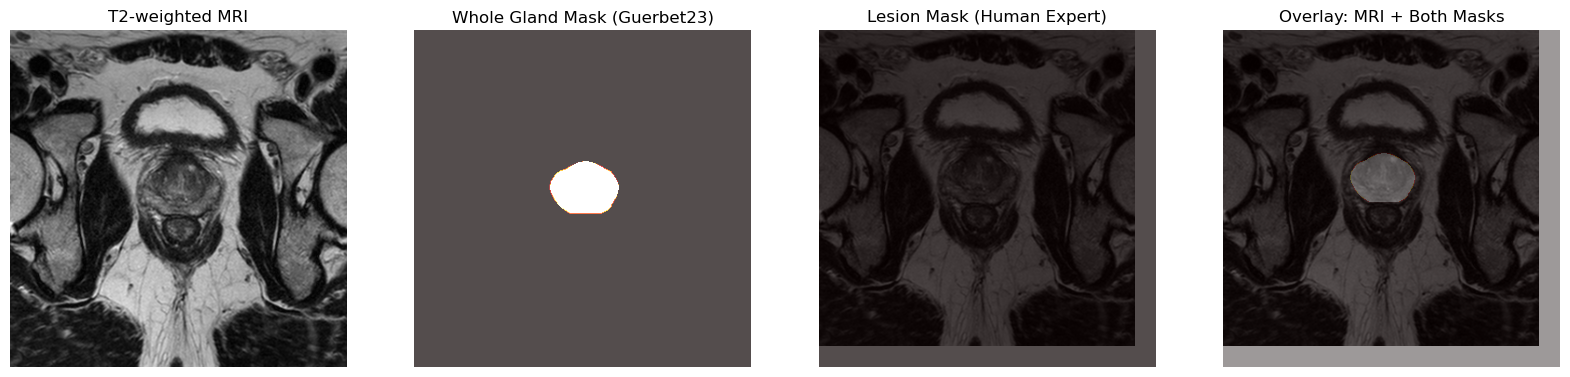

In [109]:
fileInfoT2w = '_t2w_resampled.mha'

fileInfo = '.nii.gz'
t2w_paths = find_t2W_files(source_PI_CAI_resampled, combined_ids, fileInfoT2w)
Guerbet23_nii_gz_paths = find_t2W_files(source_PI_CAI_resampled_whole_gland_Guerbet23, combined_ids, fileInfo)
Human_nii_gz_paths = find_t2W_files(source_PI_CAI_Human, combined_ids, fileInfo)

t2w_patient_ids = [path.split('\\')[-1].split("_")[0] for path in t2w_paths]
Guerbet23_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Guerbet23_nii_gz_paths]
Human_nii_gz_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Human_nii_gz_paths]


t2w_df = pd.DataFrame({'patient_id': t2w_patient_ids, 'T2w_path': t2w_paths})
Guerbet23_df = pd.DataFrame({'Guerbet23_path': Guerbet23_nii_gz_paths, 'patient_id': Guerbet23_patient_ids})
Human_df = pd.DataFrame({'Human_path': Human_nii_gz_paths, 'patient_id': Human_nii_gz_patient_ids})

df_path_merged_Human_Guerbet23 = pd.merge(Guerbet23_df, Human_df, on='patient_id')

# df_path_merged_Guerbet23 = pd.merge(t2w_df, Guerbet23_df, on='patient_id')
# df_path_merged_Human = pd.merge(t2w_df, Human_df, on='patient_id')
df_path_merge_human_guerbet23_t2w = pd.merge(df_path_merged_Human_Guerbet23, t2w_df, on='patient_id')

df_path_merge_human_guerbet23_t2w.to_csv("Data/merged_human_guerbet23.csv")


if not df_path_merge_human_guerbet23_t2w.empty:
    patient_id = df_path_merge_human_guerbet23_t2w.iloc[7]['patient_id'] 
    t2w_path = df_path_merge_human_guerbet23_t2w.iloc[7]['T2w_path']
    guerbet23_mask_path = df_path_merge_human_guerbet23_t2w.iloc[7]['Guerbet23_path']
    human_mask_path = df_path_merge_human_guerbet23_t2w.iloc[7]['Human_path']

    t2w_image = load_nifti_image(t2w_path)
    guerbet23_mask = load_nifti_image(guerbet23_mask_path)
    human_mask = load_nifti_image(human_mask_path) 

    t2w_image = t2w_image / np.max(t2w_image)

    mid_slice = t2w_image.shape[0] // 2


    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    ax[0].imshow(t2w_image[mid_slice], cmap='gray')
    ax[0].set_title("T2-weighted MRI")

    
    ax[1].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.7)
    ax[1].set_title("Whole Gland Mask (Guerbet23)")

    ax[2].imshow(t2w_image[mid_slice], cmap='gray')
    ax[2].imshow(human_mask[mid_slice], cmap='hot', alpha=0.7)
    ax[2].set_title("Lesion Mask (Human Expert)")

    ax[3].imshow(t2w_image[mid_slice], cmap='gray')
    ax[3].imshow(guerbet23_mask[mid_slice], cmap='hot', alpha=0.4)
    ax[3].imshow(human_mask[mid_slice], cmap='hot', alpha=0.4)
    ax[3].set_title("Overlay: MRI + Both Masks")

    for a in ax:
        a.axis("off")

    plt.show()
else:
    print("Merged DataFrames are empty. Please check the input data.")

def get_path_by_patient_id(df, patient_id, column_name):
    """
    Function to get the path based on patient_id.
    
    Args:
    df (pd.DataFrame): The DataFrame containing the data.
    patient_id (str): The patient ID to search for.
    column_name (str): The name of the column to retrieve the path from.
    
    Returns:
    str: The path if found, otherwise None.
    """
    if column_name not in df.columns:
        raise KeyError(f"Column '{column_name}' does not exist in the DataFrame.")
    
    # Convert patient_id to string to match the DataFrame's patient_id type
    patient_id = str(patient_id)
    
    # Check if the patient_id exists in the DataFrame
    if patient_id not in df['patient_id'].values:
        print(f"patient_id {patient_id} does not exist in the DataFrame.")
        return None
    
    result = df.loc[df['patient_id'] == patient_id, column_name]
    if not result.empty:
        return result.values[0]
    else:
        return None


In [ ]:
def show_mha_images(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".nii.gz"):
            image_path = os.path.join(folder_path, filename)
            try:
                img = sitk.ReadImage(image_path)
                arr = sitk.GetArrayFromImage(img)  # shape: [slices, height, width]
                mid_slice = arr.shape[0] // 2
                plt.imshow(arr[mid_slice], cmap='gray')
                plt.title(filename)
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"❌ Could not display {filename}: {e}")


show_mha_images("Data/picai_public_images/csPCa_lesion_delineations/human_expert/resampled")

In [88]:
guerbet23_mask_img = sitk.ReadImage(guerbet23_mask_path)
human_mask_img = sitk.ReadImage(human_mask_path)
#print(f"Whole Gland Mask shape {guerbet23_mask_img.shape}")
#print(f"Lesion Mask shape {human_mask_img.shape}")
print(f"Image size: {image_raw.GetSize()}")
print(f"Resampled image size: {image_resampled.GetSize()}")
print(f"Whole Gland Mask size: {guerbet23_mask_img.GetSize()}")
print(f"Lesion Mask size: {human_mask_img.GetSize()}")
print(f"Image spacing: {human_mask_img.GetSpacing()}")

print(f"Resampled image spacing: {image_resampled.GetSpacing()}")
print(f"Whole Gland Mask spacing: {guerbet23_mask_img.GetSpacing()}")

Image size: (640, 640, 31)
Resampled image size: (360, 360, 34)
Whole Gland Mask size: (360, 360, 34)
Lesion Mask size: (407, 400, 34)
Image spacing: (0.5, 0.5, 3.0)
Resampled image spacing: (0.5, 0.5, 3.0)
Whole Gland Mask spacing: (0.5, 0.5, 3.0)


In [140]:
fileInfoT2w = '_t2w_resampled.mha'

fileInfo = '.nii.gz'
t2w_dir = r"Data\t2w_spacing_resampled2"
guerbet_dir = r"Data\Guerbet23_resampled2"
t2w_paths = find_t2W_files(t2w_dir, combined_ids, fileInfoT2w)
Guerbet23_nii_gz_paths = find_t2W_files(guerbet_dir, combined_ids, fileInfo)

t2w_patient_ids = [path.split('\\')[-1].split("_")[0] for path in t2w_paths]
Guerbet23_patient_ids = [path.split('\\')[-1].split("_")[0] for path in Guerbet23_nii_gz_paths]
t2w_df = pd.DataFrame({'patient_id': t2w_patient_ids, 'T2w_path': t2w_paths})
Guerbet23_df = pd.DataFrame({'Guerbet23_path': Guerbet23_nii_gz_paths, 'patient_id': Guerbet23_patient_ids})
df_path_merged_Guerbet23 = pd.merge(t2w_df, Guerbet23_df, on='patient_id')

def combine_images(Guerbert23_path, Human_path):

    photo = sitk.ReadImage(Guerbert23_path)
    overlay = sitk.ReadImage(Human_path)

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(photo)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    overlay = resampler.Execute(overlay)
    overlay_resampled = resampler.Execute(overlay)
    combined_image = sitk.Cast(photo, sitk.sitkFloat32) + sitk.Cast(overlay_resampled, sitk.sitkFloat32)
    return combined_image

def check_mask(mask):
    mask_array = sitk.GetArrayFromImage(mask)
    unique_values = np.unique(mask_array)
    print(f"Unique values in mask: {unique_values}")
    if len(unique_values) <= 1:
        raise ValueError("No labels found in this mask (i.e. nothing is segmented)!")
    
def resample_mask_to_image(mask, image):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(image)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetDefaultPixelValue(0)
    resampled_mask = resampler.Execute(mask)
    return resampled_mask


def align_image_and_mask(image, mask):
    mask.SetOrigin(image.GetOrigin())  # Force same origin
    mask.SetSpacing(image.GetSpacing())  # Ensure same spacing
    mask.SetDirection(image.GetDirection())  # Align orientation
    return mask
    
def extract_intensity_features(mha_folder0):
    """Extracts first-order intensity, 2D shape, and 3D shape intensity features from all .mha files in a given folder using PyRadiomics."""

    if not os.path.exists(mha_folder0):
        print(f"ERROR: Folder {mha_folder0} does not exist!")
        return
    settings_path = os.path.join('Params.yaml')
    
    extractor = featureextractor.RadiomicsFeatureExtractor(settings_path)

    data = []

    for patient_img in os.listdir(mha_folder0):
        if patient_img.endswith(".mha"):
            image_path = os.path.join(mha_folder0, patient_img)
            patient_id = patient_img.split("_")[0]
        
        else:
            print(f"Skipping {patient_id}: No .mha file found.")
            continue
        
        try: 
            Guerbet_path = get_path_by_patient_id(Guerbet23_df, patient_id, 'Guerbet23_path')
            if Guerbet_path is None:
                print(f"⚠️ Skipping {image_path}: Mask file {Guerbet_path} not found!")
                continue 
            

            image = sitk.ReadImage(image_path)
            mask = sitk.ReadImage(Guerbet_path)
            #mask.CopyInformation(image)
            
            features = extractor.execute(image, mask)

            feature_row = {"patient_id": patient_id}
            mesh_volume = features.get("original_shape_MeshVolume", None)
            max_diameter = features.get("original_shape_Maximum3DDiameter", None)
            max2D_diameter = features.get("original_shape_Maximum2DDiameterSlice", None)

            if mesh_volume is not None and max_diameter is not None and max_diameter != 0:
                feature_row["Diameter-Volum-ratio"] = max_diameter / mesh_volume
            else:
                feature_row["Diameter-Volum-ratio"] = None

            if mesh_volume is not None and max2D_diameter is not None and max2D_diameter != 0:
                feature_row["Diameter-Volum-ratio-2D"] = max2D_diameter / mesh_volume
            else:
                feature_row["Diameter-Volum-ratio-2D"] = None

            for key, value in features.items():
                if key.startswith("original"):  # Filter out metadata keys
                    feature_row[key] = value
                    #print(key, value)
            data.append(feature_row)
        
        except Exception as e:
            print(f"Error processing {patient_id}: {e}")
    return data



In [132]:
def get_foreground_label(mask):
    """Return the most frequent non-zero label."""
    arr = sitk.GetArrayFromImage(mask)
    labels, counts = np.unique(arr[arr > 0], return_counts=True)
    if len(labels) == 0:
        return None
    dominant_label = labels[np.argmax(counts)]
    return dominant_label

def resample_mask_to_image(mask, reference_image):
    """Resample the mask to match the reference image size, spacing, and origin."""
    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(reference_image)
    resample.SetInterpolator(sitk.sitkNearestNeighbor)
    resample.SetTransform(sitk.Transform())
    resample.SetOutputPixelType(mask.GetPixelID())
    return resample.Execute(mask)

def create_binary_mask(mask, label):
    arr = sitk.GetArrayFromImage(mask)
    binary_arr = (arr == label).astype(np.uint8)
    binary_mask = sitk.GetImageFromArray(binary_arr)
    binary_mask.CopyInformation(mask)
    return binary_mask

def extract_intensity_features_Human(mha_folder0):
    """Extracts radiomics features from .mha images in a folder using PyRadiomics."""
    
    if not os.path.exists(mha_folder0):
        print(f"❌ ERROR: Folder {mha_folder0} does not exist!")
        return []
    
    settings_path = os.path.join('Params.yaml')
    extractor = featureextractor.RadiomicsFeatureExtractor(settings_path)
    data = []

    for patient_img in os.listdir(mha_folder0):
        if not patient_img.endswith(".mha"):
            continue

        image_path = os.path.join(mha_folder0, patient_img)
        patient_id = patient_img.split("_")[0]

        try:
            image = sitk.ReadImage(image_path)
            Human_path = get_path_by_patient_id(df_path_merge_human_guerbet23_t2w, patient_id, 'Human_path')
            mask_path_to_use = None
            mask = None

            if Human_path and os.path.exists(Human_path):
                mask = sitk.ReadImage(Human_path)
                arr = sitk.GetArrayFromImage(mask)
                if np.any(arr > 0):
                    mask_path_to_use = Human_path
                    label = get_foreground_label(mask)

                    if label is None:
                            print(f"❌ Error processing {patient_id}: No labels found in this mask (i.e. nothing is segmented)!")

                    binary_mask = create_binary_mask(mask, label)
                else:
                    print(f"⚠️ Human mask for {patient_id} has no labels. Trying Guerbet23 mask instead.")

            if mask_path_to_use is None:
                Guerbet_path = get_path_by_patient_id(df_path_merge_human_guerbet23_t2w, patient_id, 'Guerbet23_path')
                if Guerbet_path and os.path.exists(Guerbet_path):
                    mask = sitk.ReadImage(Guerbet_path)
                    arr = sitk.GetArrayFromImage(mask)
                    if np.any(arr > 0):
                        mask_path_to_use = Guerbet_path
                    else:
                        print(f"❌ Error processing {patient_id}: No labels found in Guerbet23 mask either!")
                        continue
                else:
                    print(f"⚠️ Skipping {patient_id}: No valid Human or Guerbet23 mask found.")
                    continue


            
            if mask_path_to_use == Human_path:
                if binary_mask.GetSize() != image.GetSize():
                    binary_mask = resample_mask_to_image(binary_mask, image)

                binary_mask.CopyInformation(image)
                features = extractor.execute(image, binary_mask)

            else:
                if mask.GetSize() != image.GetSize():
                    mask = resample_mask_to_image(mask, image)
                mask.CopyInformation(image)
                features = extractor.execute(image, mask)

            feature_row = {"patient_id": patient_id}

            # Calculating custom features
            mesh_volume = features.get("original_shape_MeshVolume")
            max_diameter = features.get("original_shape_Maximum3DDiameter")
            max2D_diameter = features.get("original_shape_Maximum2DDiameterSlice")

            feature_row["Diameter-Volum-ratio"] = (
                max_diameter / mesh_volume if mesh_volume and max_diameter else None
            )
            feature_row["Diameter-Volum-ratio-2D"] = (
                max2D_diameter / mesh_volume if mesh_volume and max2D_diameter else None
            )

            # Add all original features
            for key, value in features.items():
                if key.startswith("original"):
                    feature_row[key] = value

            data.append(feature_row)

        except Exception as e:
            print(f"❌ Error processing {patient_id}: {e}")
            continue

    return data

In [ ]:
data = []
mha_folder0 = r"Data/t2w_spacing_resampled/resampled0"
mha_folder1 = r"Data/t2w_spacing_resampled/resampled1"
mha_folder2 = r"Data/t2w_spacing_resampled/resampled2"
mha_folder3 = r"Data/t2w_spacing_resampled/resampled3"
mha_folder4 = r"Data/t2w_spacing_resampled/resampled4"
data1 = extract_intensity_features_Human(mha_folder0)
data.extend(data1)
data2 = extract_intensity_features_Human(mha_folder1)
data.extend(data2)
data3 = extract_intensity_features_Human(mha_folder2)
data.extend(data3)
data4 = extract_intensity_features_Human(mha_folder3)
data.extend(data4)
data5 = extract_intensity_features_Human(mha_folder4)
data.extend(data5)
df = pd.DataFrame(data)
df.to_csv("features_Human_mask_resample.csv")
print("\n🎉 Feature extraction complete! Data saved to 'features_all_patients.csv'.")

gc.collect()

In [ ]:
data = []
mha_folder0 = r"Data/t2w_spacing_resampled2/resampled0"
mha_folder1 = r"Data/t2w_spacing_resampled2/resampled1"
mha_folder2 = r"Data/t2w_spacing_resampled2/resampled2"
mha_folder3 = r"Data/t2w_spacing_resampled2/resampled3"
mha_folder4 = r"Data/t2w_spacing_resampled2/resampled4"
data1 = extract_intensity_features(mha_folder0)
data.extend(data1)
data2 = extract_intensity_features(mha_folder1)
data.extend(data2)
data3 = extract_intensity_features(mha_folder2)
data.extend(data3)
data4 = extract_intensity_features(mha_folder3)
data.extend(data4)
data5 = extract_intensity_features(mha_folder4)
data.extend(data5)
df = pd.DataFrame(data)
df.to_csv("features_all_patients5.csv")
print("\n🎉 Feature extraction complete! Data saved to 'features_all_patients5.csv'.")

gc.collect()


In [19]:
feature_mapping = {
        "Volume": "original_shape_MeshVolume",
        "Surface_area": "original_shape_SurfaceArea",
        "Diameter": "original_shape_Maximum3DDiameter",
        "Histogram_based": "original_firstorder_Uniformity",
        "Diameter_to_volume_ratio": "Diameter-Volum-ratio",
        "Diameter_to_volume_ratio_2D": "Diameter-Volum-ratio-2D",
        "Mean intensity": "original_firstorder_Mean",
        "Skweness": "original_firstorder_Skewness",
        "Kurtosis": "original_firstorder_Kurtosis",
        "Entropy": "original_firstorder_Entropy",
        "Sphericity": "original_shape_Sphericity",
        "Elongation": "original_shape_Elongation",
        "Compactness": "original_shape_Compactness1",
        "Surface_Area_to_Volume_ratio": "original_shape_SurfaceVolumeRatio",
        "GLCM": "original_glcm_Contrast",
        "GLRLM": "original_glrlm_RunEntropy",
        "GLSZM": "original_glszm_ZoneEntropy",
        "NGTDM_Coarseness": "original_ngtdm_Coarseness",
        "NGTDM_Contrast": "original_ngtdm_Contrast"

    }

guidelines = [
        {"guideline": "Signal intensity: T2WI guidelines mention that hypointense lesions are often high-grade and indicative of potential malignancy.",
         "feature_name": "Mean intensity", "feature_context": "lower indicates hypointense"},
         {"guideline": "Signal intensity: T2WI guidelines mention that hypointense lesions are often high-grade and indicative of potential malignancy.",
         "feature_name": "Skweness", "feature_context": "negative indicates dark lesions"},
         {"guideline": "Signal intensity: T2WI guidelines mention that hypointense lesions are often high-grade and indicative of potential malignancy.",
          "feature_name": "Kurtosis", "feature_context": "highly concentrated lesions in a small intensity range"},
         {"guideline": "Signal intensity: T2WI guidelines mention that hypointense lesions are often high-grade and indicative of potential malignancy.",
          "feature_name": "Histogram_based", "feature_context": "Histogram based features can provide information on the distribution of intensity values"},
         {"guideline": "Tumor size: Lesion size is an important factor in determining risk. Lesions larger than 1 cm are more likely to be significant.",
          "feature_name": "Volume", "feature_context": "larger lesions have higher volumes"},
         {"guideline": "Tumor size: Lesion size is an important factor in determining risk. Lesions larger than 1 cm are more likely to be significant.",
          "feature_name": "Surface_area", "feature_context": "correlated to volume"},
         {"guideline": "Tumor size: Lesion size is an important factor in determining risk. Lesions larger than 1 cm are more likely to be significant.",
          "feature_name": "Diameter", "feature_context": "Diameter of the lesion"},
         {"guideline": "Tumor size: Lesion size is an important factor in determining risk. Lesions larger than 1 cm are more likely to be significant.",
          "feature_name": "Diameter_to_volume_ratio", "feature_context": "Ratio between diameter and volume"},
          {"guideline": "Tumor size: Lesion size is an important factor in determining risk. Lesions larger than 1 cm are more likely to be significant.",
           "feature_name": "Diameter_to_volume_ratio_2D", "feature_context": "Ratio between diameter and volume in 2D"},
         {"guideline": "Shape of the tumor: Irregular or lenticular shapes are more likely to be associated with high-grade tumors.",
          "feature_name": "Sphericity", "feature_context": "Low for irregularity"},
         {"guideline": "Shape of the tumor: Irregular or lenticular shapes are more likely to be associated with high-grade tumors.",
          "feature_name": "Elongation", "feature_context": "high can indicate more irregularity"},
         {"guideline": "Shape of the tumor: Irregular or lenticular shapes are more likely to be associated with high-grade tumors.",
          "feature_name": "Compactness", "feature_context": "how close the lesion is to being spherical - non-compact is often associated with more aggressive"},
         {"guideline": "Shape of the tumor: Irregular or lenticular shapes are more likely to be associated with high-grade tumors.",
          "feature_name": "Shape_index", "feature_context": "Shape of the index"},
         {"guideline": "Margins of the tumor: Poorly defined margins indicate a higher likelihood of extraprostatic extension (EPE).",
          "feature_name": "Surface_Area_to_Volume_ratio", "feature_context": "higher are likely to have poor defined boundaries"},
         {"guideline": "Margins of the tumor: Poorly defined margins indicate a higher likelihood of extraprostatic extension (EPE).",
          "feature_name": "Entropy", "feature_context": "high indicates heterogeneity which means poorly defined margins"},
         {"guideline": "Margins of the tumor: Poorly defined margins indicate a higher likelihood of extraprostatic extension (EPE).",
          "feature_name": "GLCM", "feature_context": "e.g contrast indicates heterogeneous intensity"},
         {"guideline": "Extraprostatic extension: Indicates advanced disease with infiltration beyond the prostate.",
          "feature_name": "GLSZM", "feature_context": "(Gray-level size zone matrix), texture variations at the tumor boundary, which can be indicative of extraprostatic extension"},
         {"guideline": "Extraprostatic extension: Indicates advanced disease with infiltration beyond the prostate.",
          "feature_name": "GLRLM", "feature_context": "(Gray-level run length), texture variations at the tumor boundary, which can be indicative of extraprostatic extension"},
         {"guideline": "Extraprostatic extension: Indicates advanced disease with infiltration beyond the prostate.",
          "feature_name": "NGTDM_Coarseness", "feature_context": "Lower values indicate sharper transitions and finer edges. Higher values suggest irregular borders (more coarse and with higher contrast) and also “more disorganized tissue”, which can be correlated to more invasive tumors. "},
          {"guideline": "Extraprostatic extension: Indicates advanced disease with infiltration beyond the prostate.",
          "feature_name": "NGTDM_Contrast", "feature_context": "Lower values indicate sharper transitions and finer edges. Higher values suggest irregular borders (more coarse and with higher contrast) and also “more disorganized tissue”, which can be correlated to more invasive tumors. "}    
    ]

def create_guidelines_csv(
    features_csv_path,
    output_path,
    include_guideline=True,
    include_feature_name=True,
    include_feature_value=True,
    include_feature_context=True
):
    # Load feature data
    features_df = pd.read_csv(features_csv_path)

    rows = []

    for _, patient_row in features_df.iterrows():
        patient_id = int(patient_row["patient_id"])

        for guideline in guidelines:
            feature_name = guideline["feature_name"]
            csv_column = feature_mapping.get(feature_name)

            # Skip if the mapped feature column is missing
            if not csv_column or csv_column not in patient_row:
                continue

            feature_value = patient_row[csv_column]
            row = {
                "patient_id": patient_id
            }

            if include_guideline:
                row["guideline"] = guideline["guideline"]
            if include_feature_name:
                row["feature_name"] = feature_name
            if include_feature_value:
                row["feature_value"] = feature_value
            if include_feature_context:
                row["feature_context"] = guideline.get("feature_context", "")

            rows.append(row)
    guidelines_df = pd.DataFrame(rows)
    guidelines_df.to_csv(output_path, index=False)
    print(f"\n✅ CSV file created and saved to: '{output_path}' with {len(rows)} rows.")



In [142]:
features_csv = "features_all_patients5.csv"
output_path = "guidelines_with_features5.csv"
create_guidelines_csv(features_csv, output_path, 
                      include_guideline=True,
                      include_feature_name=True,
                      include_feature_value=True,
                      include_feature_context=True)


✅ CSV file created and saved to: 'guidelines_with_features5.csv' with 14668 rows.


In [43]:
features_csv = "features_all_patients2.csv"
output_path = "guidelines_with_features2.csv"
create_guidelines_csv(features_csv, output_path, 
                      include_guideline=True,
                      include_feature_name=True,
                      include_feature_value=True,
                      include_feature_context=True)


✅ CSV file created and saved to: 'guidelines_with_features2.csv' with 28006 rows.


In [298]:
model_name_MB = "Charangan/MedBERT"
tokenizer_MB = AutoTokenizer.from_pretrained(model_name_MB)
model_MB = AutoModel.from_pretrained(model_name_MB)
model_MB.eval()

def get_embedding_MB(text, feature_value):
    inputs = tokenizer_MB(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model_MB(**inputs)
    text_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy().squeeze()
    feature_value_array = np.array([feature_value], dtype=np.float32)
    combined_embedding = np.concatenate([text_embeddings, feature_value_array])
    return combined_embedding.astype(np.float32)


model_name_CB = "medicalai/ClinicalBERT"
tokenizer_CB = AutoTokenizer.from_pretrained(model_name_CB)
model_CB = AutoModel.from_pretrained(model_name_CB)

model_CB.eval()

def get_embedding_CB(text, feature_value):
    inputs = tokenizer_CB(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model_CB(**inputs)
    text_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy().squeeze()
    feature_value_array = np.array([feature_value], dtype=np.float32)
    combined_embedding = np.concatenate([text_embeddings, feature_value_array])
    return combined_embedding.astype(np.float32)

Model_name_Bert = "google-bert/bert-base-uncased"
tokenizer_Bert = AutoTokenizer.from_pretrained(Model_name_Bert)
model_Bert = AutoModel.from_pretrained(Model_name_Bert)


model_Bert.eval()

def get_embedding_Bert(text, feature_value):
    inputs = tokenizer_Bert(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model_Bert(**inputs)
    text_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy().squeeze()
    feature_value_array = np.array([feature_value], dtype=np.float32)
    combined_embedding = np.concatenate([text_embeddings, feature_value_array])
    return combined_embedding.astype(np.float32)

Model_name_BB = "dmis-lab/biobert-v1.1"
tokenizer_BB = AutoTokenizer.from_pretrained(Model_name_BB)
model_BB = AutoModel.from_pretrained(Model_name_BB)

model_BB.eval()

def get_embedding(text, feature_value):
    inputs = tokenizer_BB(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model_BB(**inputs)
    text_embeddings = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy().squeeze()
    feature_value_array = np.array([feature_value], dtype=np.float32)
    combined_embedding = np.concatenate([text_embeddings, feature_value_array])
    return combined_embedding.astype(np.float32)

def stack_embeddings(group):
    return np.concatenate(group['embedding'].tolist())

def save_embeddings(df, embeddings, output_path):
    df['embedding'] = embeddings
    grouped_df = df.groupby("patient_id", group_keys=False)[["embedding"]].apply(stack_embeddings).reset_index()
    grouped_df.columns = ["patient_id", "combined_embedding"]
    grouped_df["combined_embedding"] = grouped_df["combined_embedding"].apply(lambda x: json.dumps(x.tolist()))
    os.makedirs(output_path, exist_ok=True)
    grouped_df.to_csv(output_path, index=False)
    print(f"Embeddings saved to {output_path}")

def fit_logistic_regression(X_train, y_train):
    model = LogisticRegression(max_iter=5000, random_state=42, solver='liblinear', class_weight='balanced')
    model.fit(X_train, y_train)

    return model


def metrics(y_test, y_pred_probs, threshold):
    y_pred = (y_pred_probs >= threshold).astype(int)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_probs)
    f1 = f1_score(y_test, y_pred)
    sensitivity = recall_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    return bal_acc, auc, f1, sensitivity, specificity

def bootstrap_metrics(X_train, X_test, y_train, y_test, threshold, n_bootstrap=1000):
    """Performs bootstrap resampling and collects all metrics"""
    
    # Fit model once and get ORs
    model = fit_logistic_regression(X_train, y_train)
    
    boot_auc, boot_bal_acc, boot_sens, boot_spec, boot_f1 = [], [], [], [], []
    
    # Stratified resampling (to ensure label distribution is maintained in each bootstrap sample)
    sss = StratifiedShuffleSplit(n_splits=n_bootstrap, test_size=len(X_test)-5, random_state=42)
    
    for _, test_index in sss.split(X_test, y_test):  # Splitting indices based on stratification
        # Get the stratified bootstrap sample
        sample_df_test = X_test.iloc[test_index]
        sample_dep_test = y_test.iloc[test_index]
        
        # Get predicted probabilities for the resampled test data
        y_pred_probs = model.predict_proba(sample_df_test)[:, 1]
        
        # Compute performance metrics
        bal_acc, auc, f1, sens, spec = metrics(sample_dep_test, y_pred_probs, threshold)
        
        # Append metrics to the lists
        boot_auc.append(auc)
        boot_bal_acc.append(bal_acc)
        boot_sens.append(sens)
        boot_spec.append(spec)
        boot_f1.append(f1)
    
    # Compute means and 95% Confidence Intervals
    def ci(data):
        return np.mean(data), np.percentile(data, [2.5, 97.5])

    return {
        "model": model,
        "Bootstrapped Metrics": {
            "AUC": ci(boot_auc),
            "Balanced Accuracy": ci(boot_bal_acc),
            "Sensitivity": ci(boot_sens),
            "Specificity": ci(boot_spec),
            "F1-score": ci(boot_f1),
        },
        "Arrays with bootstrapping":{
            "AUC": boot_auc,
            "Balanced Accuracy": boot_bal_acc,
            "Sensitivity": boot_sens,
            "Specificity": boot_spec,
            "F1-score": boot_f1,
        }
    }

def bootstrap_metrics_full(X_train, X_test, y_train, y_test, n_bootstrap=1000, threshold=0.5):
    """Full bootstrap: resample train set, retrain model, predict on the fixed test set each time."""
    
    boot_auc, boot_bal_acc, boot_sens, boot_spec, boot_f1 = [], [], [], [], []
    
    for _ in range(n_bootstrap):
        # Resample the training data with replacement
        X_train_resampled, y_train_resampled = resample(X_train, y_train, replace=True, random_state=None)
        
        # Fit model on the resampled training data
        model = fit_logistic_regression(X_train_resampled, y_train_resampled)
        
        # Predict probabilities on the fixed test set
        y_pred_probs = model.predict_proba(X_test)[:, 1]
        
        # Compute performance metrics
        bal_acc, auc, f1, sens, spec = metrics(y_test, y_pred_probs, threshold)
        
        boot_auc.append(auc)
        boot_bal_acc.append(bal_acc)
        boot_sens.append(sens)
        boot_spec.append(spec)
        boot_f1.append(f1)
    
    # Compute means and 95% Confidence Intervals
    def ci(data):
        return np.mean(data), np.percentile(data, [2.5, 97.5])

    return {
        "Bootstrapped Metrics": {
            "AUC": ci(boot_auc),
            "Balanced Accuracy": ci(boot_bal_acc),
            "Sensitivity": ci(boot_sens),
            "Specificity": ci(boot_spec),
            "F1-score": ci(boot_f1),
        },
        "Arrays with bootstrapping": {
            "AUC": boot_auc,
            "Balanced Accuracy": boot_bal_acc,
            "Sensitivity": boot_sens,
            "Specificity": boot_spec,
            "F1-score": boot_f1,
        }
    }

def ready_for_test(df_path):
    df = pd.read_csv(df_path)
    df_marksheet = pd.read_csv("Data/Preprocessed_marksheet_all.csv")
    df_csPCa = df_marksheet.drop(columns=["study_id", "mri_date", "patient_age", "psa", "psad", "prostate_volume", "histopath_type", "lesion_GS", "lesion_ISUP", "case_ISUP", "center"])
    merge_df = pd.merge(df_csPCa, df, on="patient_id", how="left")
    merge_df = merge_df.dropna()
    y = merge_df["case_csPCa"].values
    merge_df = merge_df.drop(columns=["patient_id", "case_csPCa"])
    X = np.vstack(merge_df["combined_embedding"].apply(lambda x: np.array(json.loads(x))).values)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_test = pd.DataFrame(X_test)
    y_test = pd.Series(y_test)
    return X_train, X_test, y_train, y_test


def summarize_results(model_name, embeddings, context, feat_name, feat_expl, bootstrap_results):
    summary = bootstrap_results["Bootstrapped Metrics"]
    return {
        "Model": model_name,
        "Embedding": embeddings,
        "Context": context,
        "Feature Name": feat_name,
        "Feature Explanation": feat_expl,
        "AUC (95% CI)": f"{summary['AUC'][0]:.3f} ({summary['AUC'][1][0]:.3f}-{summary['AUC'][1][1]:.3f})",
        "Balanced Accuracy (95% CI)": f"{summary['Balanced Accuracy'][0]:.3f} ({summary['Balanced Accuracy'][1][0]:.3f}-{summary['Balanced Accuracy'][1][1]:.3f})",
        "F1 (95% CI)": f"{summary['F1-score'][0]:.3f} ({summary['F1-score'][1][0]:.3f}-{summary['F1-score'][1][1]:.3f})",
        "Sensitivity (95% CI)": f"{summary['Sensitivity'][0]:.3f} ({summary['Sensitivity'][1][0]:.3f}-{summary['Sensitivity'][1][1]:.3f})",
        "Specificity (95% CI)": f"{summary['Specificity'][0]:.3f} ({summary['Specificity'][1][0]:.3f}-{summary['Specificity'][1][1]:.3f})"
    }


def add_to_table(model_name, embeddings, context, feat_name, feat_expl, bootstrap_results):
    summary = summarize_results(model_name, embeddings, context, feat_name, feat_expl, bootstrap_results)
    df_table = pd.read_csv("Data/Results_table2.csv")
    df_summary = pd.DataFrame([summary])
    df_table = pd.concat([df_table, df_summary], ignore_index=True)
    df_table.to_csv("Data/Results_table2.csv", index=False)

def process(model, embeddings, guideline, feature_name, feature_context):
    df = pd.read_csv("guidelines_with_features3.csv")
    if guideline == "Yes" and feature_name == "Yes" and feature_context == "Yes":
        if model == "BioBERT":
            embedding = df.apply(lambda x: get_embedding(x["guideline"] + " " + x["feature_name"] + " " + x["feature_context"], x["feature_value"]), axis=1)
        elif model == "ClinicalBERT":
            embedding = df.apply(lambda x: get_embedding_CB(x["guideline"] + " " + x["feature_name"] + " " + x["feature_context"], x["feature_value"]), axis=1)
        elif model == "BERT":
            embedding = df.apply(lambda x: get_embedding_Bert(x["guideline"] + " " + x["feature_name"] + " " + x["feature_context"], x["feature_value"]), axis=1)
        elif model == "MedBERT":
            embedding = df.apply(lambda x: get_embedding_MB(x["guideline"] + " " + x["feature_name"] + " " + x["feature_context"], x["feature_value"]), axis=1)
    elif guideline == "Yes" and feature_name == "Yes" and feature_context == "No":
        if model == "BioBERT":
            embedding = df.apply(lambda x: get_embedding(x["guideline"] + " " + x["feature_name"], x["feature_value"]), axis=1)
        elif model == "ClinicalBERT":
            embedding = df.apply(lambda x: get_embedding_CB(x["guideline"] + " " + x["feature_name"], x["feature_value"]), axis=1)
        elif model == "BERT":
            embedding = df.apply(lambda x: get_embedding_Bert(x["guideline"] + " " + x["feature_name"], x["feature_value"]), axis=1)
        elif model == "MedBERT":
            embedding = df.apply(lambda x: get_embedding_MB(x["guideline"] + " " + x["feature_name"], x["feature_value"]), axis=1)
    elif guideline == "Yes" and feature_name == "No" and feature_context == "Yes":
        if model == "BioBERT":
            embedding = df.apply(lambda x: get_embedding(x["guideline"] + " " + x["feature_context"], x["feature_value"]), axis=1)
        elif model == "ClinicalBERT":
            embedding = df.apply(lambda x: get_embedding_CB(x["guideline"] + " " + x["feature_context"], x["feature_value"]), axis=1)
        elif model == "BERT":
            embedding = df.apply(lambda x: get_embedding_Bert(x["guideline"] + " " + x["feature_context"], x["feature_value"]), axis=1)
        elif model == "MedBERT":
            embedding = df.apply(lambda x: get_embedding_MB(x["guideline"] + " " + x["feature_context"], x["feature_value"]), axis=1)
    elif guideline == "Yes" and feature_name == "No" and feature_context == "No":
        if model == "BioBERT":
            embedding = df.apply(lambda x: get_embedding(x["guideline"], x["feature_value"]), axis=1)
        elif model == "ClinicalBERT":
            embedding = df.apply(lambda x: get_embedding_CB(x["guideline"], x["feature_value"]), axis=1)
        elif model == "BERT":
            embedding = df.apply(lambda x: get_embedding_Bert(x["guideline"], x["feature_value"]), axis=1)
        elif model == "MedBERT":
            embedding = df.apply(lambda x: get_embedding_MB(x["guideline"], x["feature_value"]), axis=1)
    elif guideline == "No" and feature_name == "Yes" and feature_context == "Yes":
        if model == "BioBERT":
            embedding = df.apply(lambda x: get_embedding(x["feature_name"] + " " + x["feature_context"], x["feature_value"]), axis=1)
        elif model == "ClinicalBERT":
            embedding = df.apply(lambda x: get_embedding_CB(x["feature_name"] + " " + x["feature_context"], x["feature_value"]), axis=1)
        elif model == "BERT":
            embedding = df.apply(lambda x: get_embedding_Bert(x["feature_name"] + " " + x["feature_context"], x["feature_value"]), axis=1)
        elif model == "MedBERT":
            embedding = df.apply(lambda x: get_embedding_MB(x["feature_name"] + " " + x["feature_context"], x["feature_value"]), axis=1)
    elif guideline == "No" and feature_name == "Yes" and feature_context == "No":
        if model == "BioBERT":
            embedding = df.apply(lambda x: get_embedding(x["feature_name"], x["feature_value"]), axis=1)
        elif model == "ClinicalBERT":
            embedding = df.apply(lambda x: get_embedding_CB(x["feature_name"], x["feature_value"]), axis=1)
        elif model == "BERT":
            embedding = df.apply(lambda x: get_embedding_Bert(x["feature_name"], x["feature_value"]), axis=1)
        elif model == "MedBERT":
            embedding = df.apply(lambda x: get_embedding_MB(x["feature_name"], x["feature_value"]), axis=1)
    elif guideline == "No" and feature_name == "No" and feature_context == "Yes":
        if model == "BioBERT":
            embedding = df.apply(lambda x: get_embedding(x["feature_context"], x["feature_value"]), axis=1)
        elif model == "ClinicalBERT":
            embedding = df.apply(lambda x: get_embedding_CB(x["feature_context"], x["feature_value"]), axis=1)
        elif model == "BERT":
            embedding = df.apply(lambda x: get_embedding_Bert(x["feature_context"], x["feature_value"]), axis=1)
        elif model == "MedBERT":
            embedding = df.apply(lambda x: get_embedding_MB(x["feature_context"], x["feature_value"]), axis=1)
    elif guideline == "No" and feature_name == "No" and feature_context == "No":
        if model == "BioBERT":
            embedding = df.apply(lambda x: get_embedding("", x["feature_value"]), axis=1)
        elif model == "ClinicalBERT":
            embedding = df.apply(lambda x: get_embedding_CB("", x["feature_value"]), axis=1)
        elif model == "BERT":
            embedding = df.apply(lambda x: get_embedding_Bert("", x["feature_value"]), axis=1)
        elif model == "MedBERT":
            embedding = df.apply(lambda x: get_embedding_MB("", x["feature_value"]), axis=1)
    else:
        print("Invalid combination of guideline, feature_name, and feature_context.")

    save_embeddings(df, embedding, f"Data/embeddings/{model}_2/{model}_{guideline}_{feature_name}_{feature_context}.csv")
    X_train, X_test, y_train, y_test = ready_for_test(f"Data/embeddings/{model}_2/{model}_{guideline}_{feature_name}_{feature_context}.csv")
    results = bootstrap_metrics(X_train, X_test, y_train, y_test, threshold=0.535, n_bootstrap=1000)
    add_to_table(model, embeddings, guideline, feature_name, feature_context, results)

In [278]:
process("BioBERT", "Yes", "Yes", "Yes", "Yes")

Embeddings saved to Data/embeddings/BioBERT_3/BioBERT_Yes_Yes_Yes.csv


In [293]:
X_train, X_test, y_train, y_test = ready_for_test("Data/embeddings/BioBERT_2/BioBERT_Yes_Yes_Yes.csv")
results = bootstrap_metrics(X_train, X_test, y_train, y_test, threshold=0.535, n_bootstrap=1000)
add_to_table("BioBERT", "Yes", "Yes", "Yes", "Yes", results)

Beste resultat så langt er med features og guidelines nr 3, med threshold 0.535, gjort med resampled bilder nr2 og binwidth 5 

In [58]:
X_train, X_test, y_train, y_test = ready_for_test("Data/embeddings/BioBERT/BioBERT_Yes_Yes_Yes.csv")
results = bootstrap_metrics_full(X_train, X_test, y_train, y_test, n_bootstrap=1000, threshold=0.5)
add_to_table("BioBERT", "Yes", "Yes", "Yes", "Yes", results)

In [171]:
df_features = pd.read_csv("features_all_patients3.csv")
df_marksheet = pd.read_csv("Data/Preprocessed_marksheet_all.csv")

df_csPCa = df_marksheet.drop(columns=["study_id", "mri_date", "patient_age", "psa", "psad", "prostate_volume", "histopath_type", "lesion_GS", "lesion_ISUP", "case_ISUP", "center"])
df_features.drop(columns=["Unnamed: 0"], inplace=True)

merge_df = pd.merge(df_csPCa, df_features, on="patient_id", how="left")
merge_df = merge_df.dropna()
y = merge_df["case_csPCa"].values
merge_df = merge_df.drop(columns=["patient_id", "case_csPCa"])
X_raw = merge_df.values
df_X = pd.DataFrame(X_raw, columns=merge_df.columns)
X_train, X_test, y_train, y_test = train_test_split(df_X, y, test_size=0.3, random_state=42, stratify=y)

X_test = pd.DataFrame(X_test)
y_test = pd.Series(y_test)
bootstrap_results_model = bootstrap_metrics(X_train, X_test, y_train, y_test, n_bootstrap=1000, threshold=0.535)
add_to_table("Radiomic features", "No", "No", "No", "No", bootstrap_results_model)

In [189]:
df_marksheet = pd.read_csv("Data/Preprocessed_marksheet_all.csv")

y = df_marksheet["case_csPCa"].values
X = df_marksheet.drop(columns=["study_id", "mri_date", "histopath_type", "lesion_GS", "lesion_ISUP", "case_ISUP", "center", "patient_id", "case_csPCa"]).values
X = pd.DataFrame(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test = pd.DataFrame(X_test)
y_test = pd.Series(y_test)
bootstrap_results_model = bootstrap_metrics(X_train, X_test, y_train, y_test, threshold=0.535, n_bootstrap=1000)
add_to_table("Clinical features", "No", "No", "No", "No", bootstrap_results_model)

In [282]:
process("BioBERT", "Yes", "Yes", "Yes", "No")

Embeddings saved to Data/embeddings/BioBERT_3/BioBERT_Yes_Yes_No.csv


In [283]:
process("BioBERT", "Yes", "Yes", "No", "Yes")

Embeddings saved to Data/embeddings/BioBERT_3/BioBERT_Yes_No_Yes.csv


In [284]:
process("BioBERT", "Yes", "Yes", "No", "No")

Embeddings saved to Data/embeddings/BioBERT_3/BioBERT_Yes_No_No.csv


In [285]:
process("BioBERT", "Yes", "No", "Yes", "Yes")

Embeddings saved to Data/embeddings/BioBERT_3/BioBERT_No_Yes_Yes.csv


In [286]:
process("BioBERT", "Yes", "No", "Yes", "No")

Embeddings saved to Data/embeddings/BioBERT_3/BioBERT_No_Yes_No.csv


In [287]:
process("BioBERT", "Yes", "No", "No", "Yes")

Embeddings saved to Data/embeddings/BioBERT_3/BioBERT_No_No_Yes.csv


In [288]:
process("BioBERT", "Yes", "No", "No", "No")

Embeddings saved to Data/embeddings/BioBERT_3/BioBERT_No_No_No.csv


In [289]:
process("BERT", "Yes", "Yes", "Yes", "Yes")
process("BERT", "Yes", "Yes", "Yes", "No")
process("BERT", "Yes", "Yes", "No", "Yes")
process("BERT", "Yes", "Yes", "No", "No")
process("BERT", "Yes", "No", "Yes", "Yes")
process("BERT", "Yes", "No", "Yes", "No")
process("BERT", "Yes", "No", "No", "Yes")
process("BERT", "Yes", "No", "No", "No")

Embeddings saved to Data/embeddings/BERT_3/BERT_Yes_Yes_Yes.csv
Embeddings saved to Data/embeddings/BERT_3/BERT_Yes_Yes_No.csv
Embeddings saved to Data/embeddings/BERT_3/BERT_Yes_No_Yes.csv
Embeddings saved to Data/embeddings/BERT_3/BERT_Yes_No_No.csv
Embeddings saved to Data/embeddings/BERT_3/BERT_No_Yes_Yes.csv
Embeddings saved to Data/embeddings/BERT_3/BERT_No_Yes_No.csv
Embeddings saved to Data/embeddings/BERT_3/BERT_No_No_Yes.csv
Embeddings saved to Data/embeddings/BERT_3/BERT_No_No_No.csv


In [297]:
process("ClinicalBERT", "Yes", "Yes", "Yes", "Yes")
process("ClinicalBERT", "Yes", "Yes", "Yes", "No")
process("ClinicalBERT", "Yes", "Yes", "No", "Yes")
process("ClinicalBERT", "Yes", "Yes", "No", "No")
process("ClinicalBERT", "Yes", "No", "Yes", "Yes")
process("ClinicalBERT", "Yes", "No", "Yes", "No")
process("ClinicalBERT", "Yes", "No", "No", "Yes")
process("ClinicalBERT", "Yes", "No", "No", "No")

Embeddings saved to Data/embeddings/ClinicalBERT_2/ClinicalBERT_Yes_Yes_Yes.csv
Embeddings saved to Data/embeddings/ClinicalBERT_2/ClinicalBERT_Yes_Yes_No.csv
Embeddings saved to Data/embeddings/ClinicalBERT_2/ClinicalBERT_Yes_No_Yes.csv
Embeddings saved to Data/embeddings/ClinicalBERT_2/ClinicalBERT_Yes_No_No.csv
Embeddings saved to Data/embeddings/ClinicalBERT_2/ClinicalBERT_No_Yes_Yes.csv
Embeddings saved to Data/embeddings/ClinicalBERT_2/ClinicalBERT_No_Yes_No.csv
Embeddings saved to Data/embeddings/ClinicalBERT_2/ClinicalBERT_No_No_Yes.csv
Embeddings saved to Data/embeddings/ClinicalBERT_2/ClinicalBERT_No_No_No.csv


In [ ]:
process("MedBERT", "Yes", "Yes", "Yes", "Yes")
process("MedBERT", "Yes", "Yes", "Yes", "No")
process("MedBERT", "Yes", "Yes", "No", "Yes")
process("MedBERT", "Yes", "Yes", "No", "No")
process("MedBERT", "Yes", "No", "Yes", "Yes")
process("MedBERT", "Yes", "No", "Yes", "No")
process("MedBERT", "Yes", "No", "No", "Yes")
process("MedBERT", "Yes", "No", "No", "No")

Embeddings saved to Data/embeddings/MedBERT_2/MedBERT_Yes_Yes_No.csv
Embeddings saved to Data/embeddings/MedBERT_2/MedBERT_Yes_No_Yes.csv
Embeddings saved to Data/embeddings/MedBERT_2/MedBERT_Yes_No_No.csv
Embeddings saved to Data/embeddings/MedBERT_2/MedBERT_No_Yes_Yes.csv
Embeddings saved to Data/embeddings/MedBERT_2/MedBERT_No_Yes_No.csv
Embeddings saved to Data/embeddings/MedBERT_2/MedBERT_No_No_Yes.csv
Embeddings saved to Data/embeddings/MedBERT_2/MedBERT_No_No_No.csv


In [33]:
X_train, X_test, y_train, y_test = ready_for_test("Data/embeddings/BioBERT/BioBERT_Yes_Yes_Yes.csv")
results = bootstrap_metrics(X_train, X_test, y_train, y_test, n_bootstrap=1000, threshold=0.5)
add_to_table("BioBERT", "Yes", "Yes", "Yes", "Yes", results)

In [68]:
df_features = pd.read_csv("features_all_patients2.csv")
df_marksheet = pd.read_csv("Data/Preprocessed_marksheet_all.csv")

df_csPCa = df_marksheet.drop(columns=["study_id", "mri_date", "patient_age", "psa", "psad", "prostate_volume", "histopath_type", "lesion_GS", "lesion_ISUP", "case_ISUP", "center"])
df_features.drop(columns=["Unnamed: 0"], inplace=True)

merge_df = pd.merge(df_csPCa, df_features, on="patient_id", how="left")
merge_df = merge_df.dropna()
y = merge_df["case_csPCa"].values
merge_df = merge_df.drop(columns=["patient_id", "case_csPCa"])
X_raw = merge_df.values
df_X = pd.DataFrame(X_raw, columns=merge_df.columns)
X_train, X_test, y_train, y_test = train_test_split(df_X, y, test_size=0.3, random_state=42, stratify=y)

X_test = pd.DataFrame(X_test)
y_test = pd.Series(y_test)
bootstrap_results_model = bootstrap_metrics(X_train, X_test, y_train, y_test, n_bootstrap=1000, threshold=0.5)
add_to_table("Logistic Regression", "No", "No", "No", "No", bootstrap_results_model)

In [26]:
df = pd.read_csv("Data/Results_table.csv")
df

,Model,Embedding,Context,Feature Name,Feature Explanation,AUC (95% CI),Balanced Accuracy (95% CI),F1 (95% CI),Sensitivity (95% CI),Specificity (95% CI)
0,Radiomics features,No,No,No,No,0.652 (0.645-0.661),0.601 (0.596-0.609),0.338 (0.333-0.345),0.682 (0.677-0.692),0.520 (0.514-0.527)
1,BIOBERT,Yes,Yes,Yes,Yes,0.728 (0.722-0.735),0.659 (0.655-0.667),0.390 (0.385-0.397),0.727 (0.723-0.738),0.591 (0.586-0.599)
2,BIOBERT,Yes,Yes,Yes,No,0.728 (0.722-0.735),0.659 (0.655-0.667),0.390 (0.385-0.397),0.727 (0.723-0.738),0.591 (0.586-0.599)
3,BIOBERT,Yes,Yes,No,Yes,0.728 (0.722-0.735),0.659 (0.655-0.667),0.390 (0.385-0.397),0.727 (0.723-0.738),0.591 (0.586-0.599)
4,BIOBERT,Yes,Yes,No,No,0.728 (0.722-0.735),0.659 (0.655-0.667),0.390 (0.385-0.397),0.727 (0.723-0.738),0.591 (0.586-0.599)
5,BIOBERT,Yes,No,Yes,Yes,0.728 (0.723-0.736),0.667 (0.662-0.675),0.396 (0.392-0.403),0.742 (0.738-0.754),0.591 (0.586-0.599)
6,BIOBERT,Yes,No,No,Yes,0.728 (0.723-0.736),0.659 (0.655-0.667),0.390 (0.385-0.397),0.727 (0.723-0.738),0.591 (0.586-0.599)
7,BIOBERT,Yes,No,Yes,No,0.728 (0.722-0.735),0.659 (0.655-0.667),0.390 (0.385-0.397),0.727 (0.723-0.738),0.591 (0.586-0.599)
8,BIOBERT,Yes,No,No,No,0.728 (0.723-0.736),0.667 (0.662-0.675),0.396 (0.392-0.403),0.742 (0.738-0.754),0.591 (0.586-0.599)
9,BERT,Yes,Yes,Yes,Yes,0.728 (0.722-0.735),0.659 (0.655-0.667),0.390 (0.385-0.397),0.727 (0.723-0.738),0.591 (0.586-0.599)


In [ ]:
metrics_dict = bert_model_test["Arrays with bootstrapping"]

for metric_name, values in metrics_dict.items():
    plt.figure(figsize=(6,4))
    plt.hist(values, bins=30, color="skyblue", edgecolor="black")
    plt.title(f"Bootstrap distribution of {metric_name}")
    plt.xlabel(metric_name)
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [40]:
text1 = "This is a prostate guideline related to lesion size"
text2 = "This is a modified prostate guideline without feature context"

embedding1 = get_embedding_CB(text1, 0.85)
embedding2 = get_embedding_CB(text2, 0.85)

from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity([embedding1], [embedding2])[0][0]
print(f"Similarity between different texts: {similarity:.6f}")

Similarity between different texts: 0.993704


In [ ]:
df = pd.read_csv("guidelines_with_features_test.csv")
embeddings2 = df.apply(lambda x: get_embedding_CB("", x["feature_value"]), axis=1)

In [7]:
df_mod = pd.read_csv("Data/embeddings/CB/clinicalbert_embeddings_onlyvalue.csv")
df_original = pd.read_csv("Data/embeddings/CB/clinicalbert_embeddings.csv")
original_embedding = np.array(eval(df_original.loc[0, "combined_embedding"]))  # if stored as string
modified_embedding = np.array(eval(df_mod.loc[0, "combined_embedding"]))

similarity = cosine_similarity([original_embedding], [modified_embedding])[0][0]
print(f"Cosine similarity between original and modified: {similarity:.4f}")

Cosine similarity between original and modified: 1.0000


Text(0.5, 1.0, 'Whole Gland Mask (Guerbet23)')

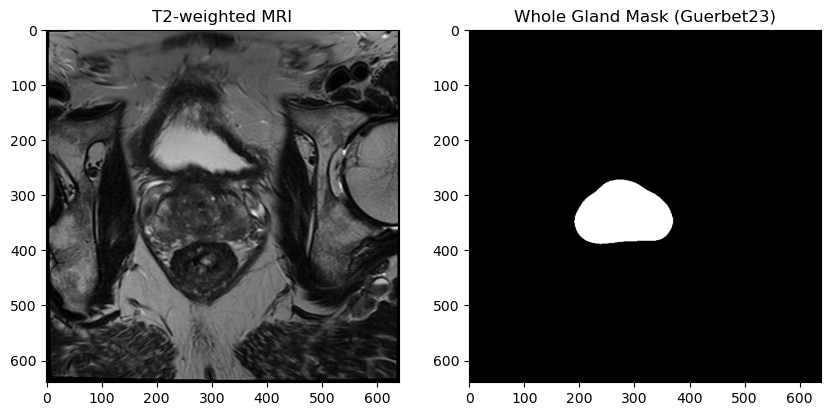

In [234]:
t2w_image = sitk.GetArrayFromImage(sitk.ReadImage("Data/picai_public_images/picai_public_images_fold0/10000/10000_1000000_t2w.mha"))
guerbet23_mask = sitk.GetArrayFromImage(sitk.ReadImage("Data/picai_public_images/anatomical_delineations/whole_gland/AI/Guerbet23/10000_1000000.nii.gz"))

t2w_image = t2w_image / np.max(t2w_image)
mid_slice = t2w_image.shape[0] // 2

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(t2w_image[mid_slice], cmap='gray')
ax[0].set_title("T2-weighted MRI")

ax[1].imshow(guerbet23_mask[mid_slice], cmap='gray')
ax[1].set_title("Whole Gland Mask (Guerbet23)")
